In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

Failed to load image Python extension: /mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
2025-02-05 13:26:50.687245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738758410.701775  134117 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738758410.707175  134117 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup imports

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
import monai
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader, NibabelReader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, RandAffined, CastToTyped
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.12.0+cu102
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
root_dir = '/mnt/nfs/home/liglesias/data_all'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")

Se encontraron 1048 archivos en /mnt/nfs/home/liglesias/data_all/masks_training
Se encontraron 612 archivos en /mnt/nfs/home/liglesias/data_all/masks_testing


(232, 256, 10)
(200, 256, 10)
(216, 256, 11)
(240, 256, 10)
(216, 256, 10)


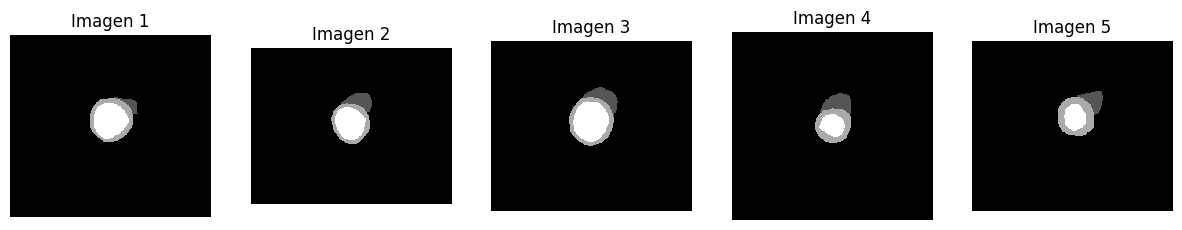

In [6]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [7]:
all_files = training_files + testing_files

images = [nib.load(file).get_fdata() for file in all_files]

image_shapes = [img.shape for img in images]
print(image_shapes)

average_shape = np.mean(image_shapes, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")

min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)

print(f"Tamaño mínimo -original: {min_shape}")
print(f"Tamaño máximo -original: {max_shape}")

[(232, 256, 10), (200, 256, 10), (216, 256, 11), (240, 256, 10), (216, 256, 10), (192, 256, 11), (216, 256, 10), (224, 256, 10), (216, 256, 7), (232, 256, 9), (216, 256, 7), (216, 256, 9), (428, 512, 8), (216, 256, 9), (256, 176, 8), (216, 256, 10), (192, 256, 10), (208, 256, 7), (214, 256, 8), (216, 256, 9), (216, 256, 9), (184, 288, 15), (256, 184, 8), (180, 224, 10), (180, 224, 14), (174, 208, 18), (216, 256, 8), (216, 304, 8), (256, 256, 11), (256, 256, 11), (336, 336, 12), (320, 320, 10), (320, 320, 10), (196, 240, 10), (256, 208, 9), (240, 196, 14), (240, 196, 12), (352, 352, 10), (320, 320, 10), (320, 320, 11), (352, 352, 12), (384, 384, 11), (256, 208, 8), (256, 256, 12), (512, 512, 13), (320, 320, 10), (352, 352, 11), (336, 336, 9), (320, 320, 10), (320, 320, 10), (240, 196, 12), (256, 208, 12), (240, 196, 12), (210, 256, 13), (256, 208, 8), (320, 320, 10), (336, 336, 10), (336, 336, 10), (240, 196, 12), (240, 196, 14), (320, 320, 10), (336, 336, 10), (336, 336, 10), (240, 196

In [8]:
images_train = [nib.load(file).get_fdata() for file in training_files]
images_test = [nib.load(file).get_fdata() for file in testing_files]
image_shapes_train = [img.shape for img in images_train]
image_shapes_test = [img.shape for img in images_test]
print(image_shapes_train)
print(image_shapes_test)

[(232, 256, 10), (200, 256, 10), (216, 256, 11), (240, 256, 10), (216, 256, 10), (192, 256, 11), (216, 256, 10), (224, 256, 10), (216, 256, 7), (232, 256, 9), (216, 256, 7), (216, 256, 9), (428, 512, 8), (216, 256, 9), (256, 176, 8), (216, 256, 10), (192, 256, 10), (208, 256, 7), (214, 256, 8), (216, 256, 9), (216, 256, 9), (184, 288, 15), (256, 184, 8), (180, 224, 10), (180, 224, 14), (174, 208, 18), (216, 256, 8), (216, 304, 8), (256, 256, 11), (256, 256, 11), (336, 336, 12), (320, 320, 10), (320, 320, 10), (196, 240, 10), (256, 208, 9), (240, 196, 14), (240, 196, 12), (352, 352, 10), (320, 320, 10), (320, 320, 11), (352, 352, 12), (384, 384, 11), (256, 208, 8), (256, 256, 12), (512, 512, 13), (320, 320, 10), (352, 352, 11), (336, 336, 9), (320, 320, 10), (320, 320, 10), (240, 196, 12), (256, 208, 12), (240, 196, 12), (210, 256, 13), (256, 208, 8), (320, 320, 10), (336, 336, 10), (336, 336, 10), (240, 196, 12), (240, 196, 14), (320, 320, 10), (336, 336, 10), (336, 336, 10), (240, 196

## Set deterministic training for reproducibility

In [9]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

In [ ]:
preprocess_list1 = [
    transforms.LoadImaged(keys=["image"], reader=NibabelReader()),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"], track_meta=True),
    # transforms.Orientationd(keys=["image"], axcodes="LPS"),
    transforms.Spacingd(keys=["image"], pixdim=(1.3307291865348816, 1.3307291269302368, 5), mode='nearest'), # pixdim=(1.52344, 1.52344, 10.0)
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
]

training_data_aug = [
    transforms.RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
    transforms.RandFlipd(keys=["image"], spatial_axis=1, prob=0.5),
    transforms.RandFlipd(keys=["image"], spatial_axis=2, prob=0.5),
    transforms.RandAffined(keys=["image"], mode="nearest", scale_range=(0, 0.2, 0.2),
                        rotate_range=(1.0, 0, 0), padding_mode="zeros", prob=7.0),
    
]

preprocess_list2 = [
    transforms.CropForegroundd(keys=["image"], source_key="image", allow_smaller=False),
    transforms.SpatialPadd(keys=["image"], spatial_size=(24, 128, 128)),
    transforms.Resized(keys=["image"], spatial_size=(24, 128, 128), mode="nearest"),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
]

all_transforms = transforms.Compose(preprocess_list1 + training_data_aug + preprocess_list2)
validation_transforms = transforms.Compose(preprocess_list1 + preprocess_list2)

postprocessing_training = transforms.Compose([
    transforms.AsDiscreted(keys=["pred"], argmax=True),
    transforms.EnsureTyped(keys=["pred"], dtype=int),
    transforms.Invertd(keys=["pred"], transform=all_transforms, orig_keys="image"),
    transforms.SaveImaged(keys=["pred"], 
                          meta_keys=["image_meta_data"], 
                          output_dir="reconstructed_masks_testing_all", 
                          output_postfix="reconstructed", 
                          output_ext=".nii.gz",
                          data_root_dir=root_dir,
                          separate_folder=False),
])

postprocessing_testing = transforms.Compose([
    transforms.AsDiscreted(keys=["pred"], argmax=True),
    transforms.EnsureTyped(keys=["pred"], dtype=int),
    transforms.Invertd(keys=["pred"], transform=validation_transforms, orig_keys="image"),
    transforms.SaveImaged(keys=["pred"], 
                          meta_keys=["image_meta_data"], 
                          output_dir="reconstructed_masks_testing_all", 
                          output_postfix="reconstructed", 
                          output_ext=".nii.gz",
                          data_root_dir=root_dir,
                          separate_folder=False),
])

In [11]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [12]:
val_data_dicts = [{"image": file} for file in testing_files][0:1]
transform = Compose(validation_transforms)
transform(val_data_dicts)[0]['image'].shape

torch.Size([4, 24, 128, 128])

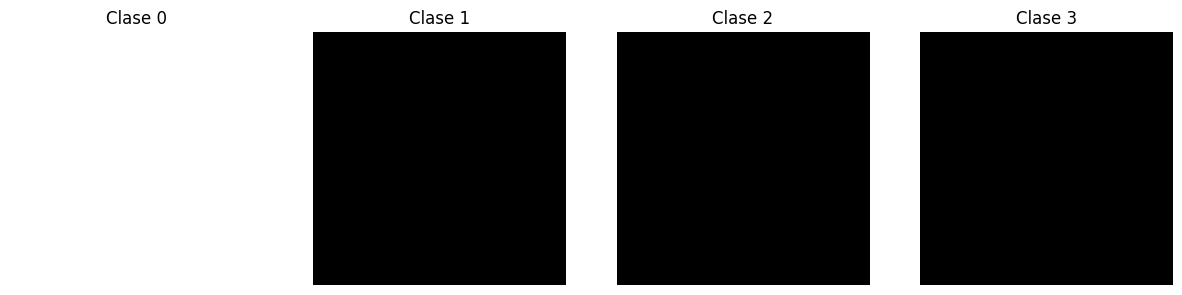

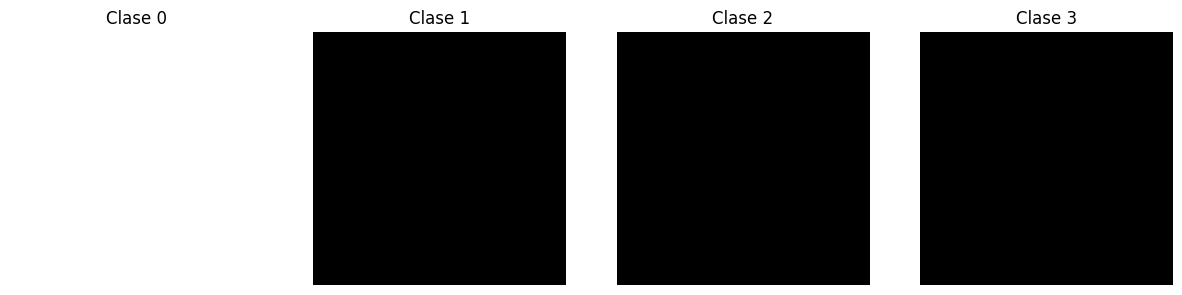

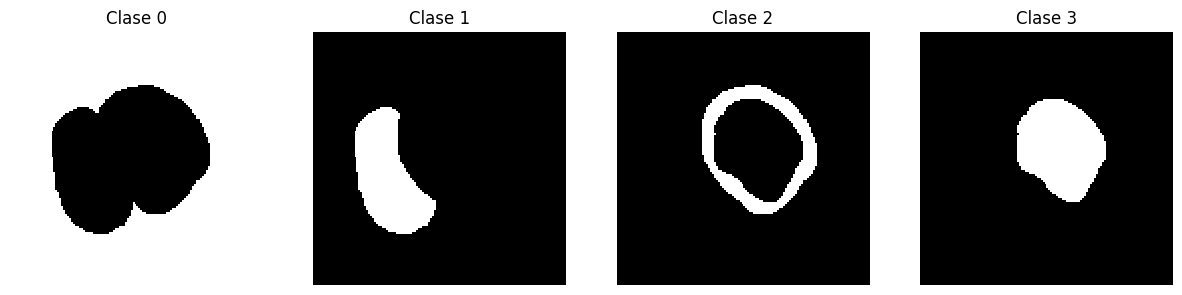

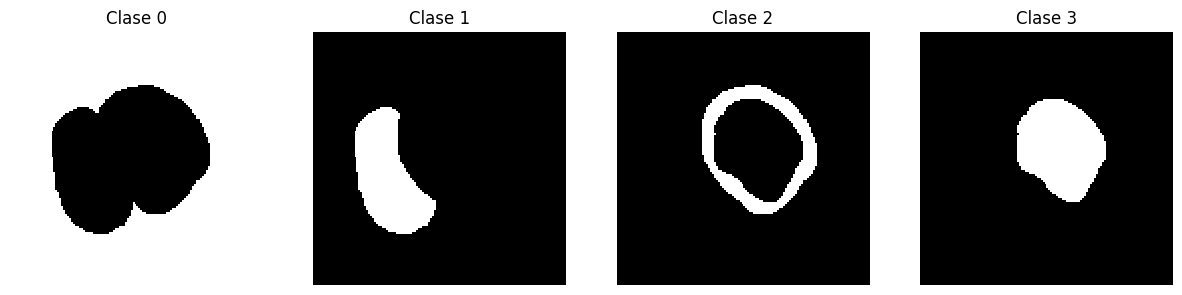

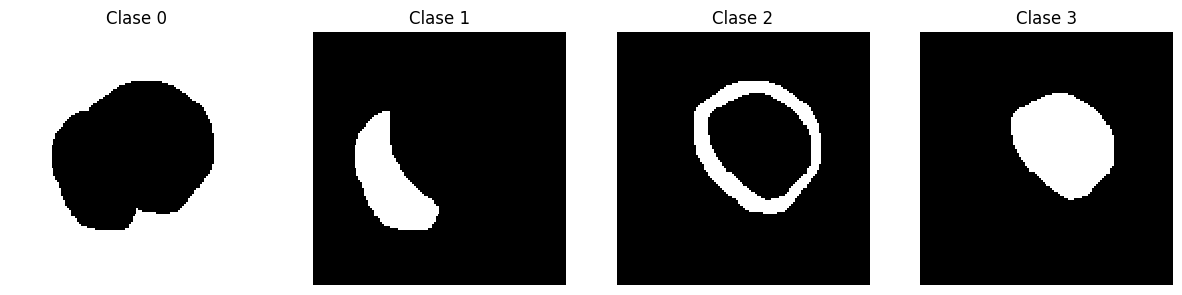

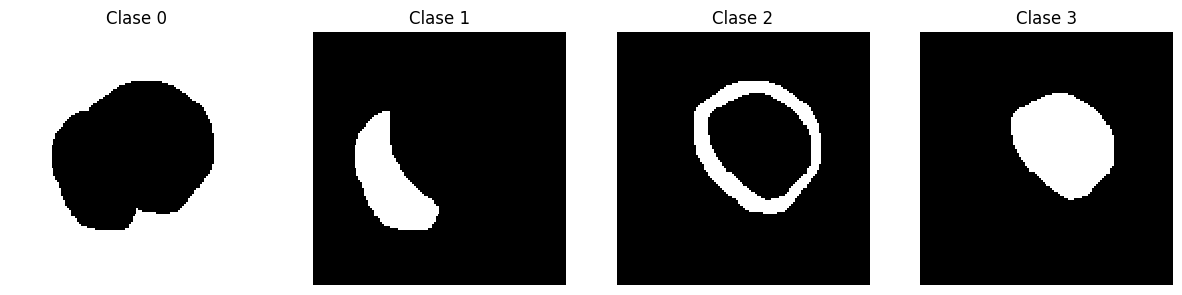

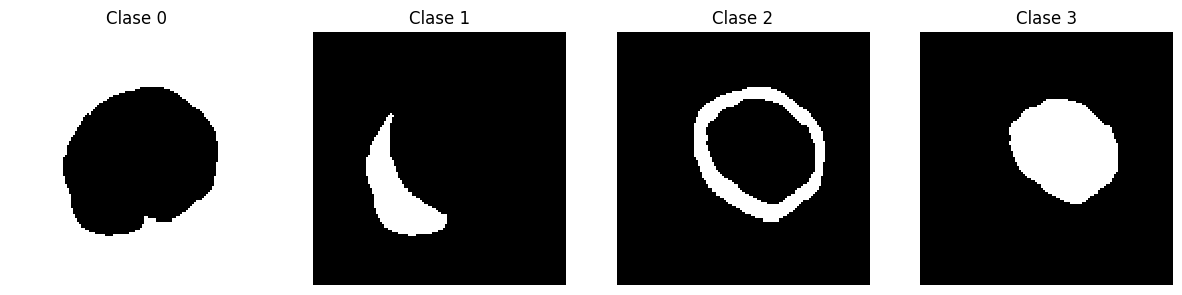

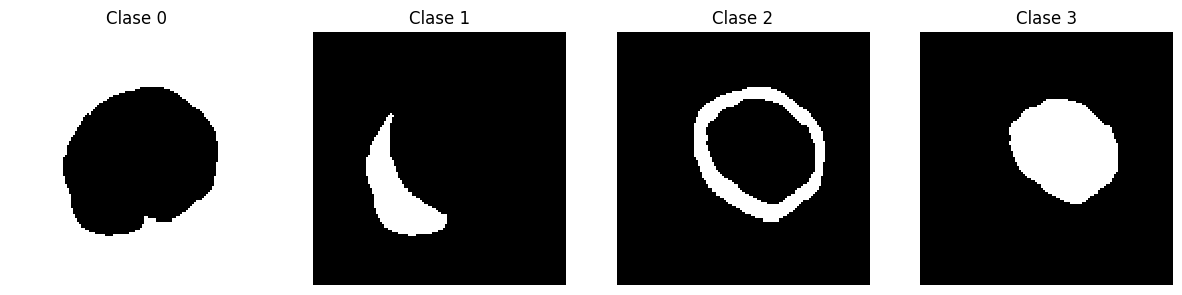

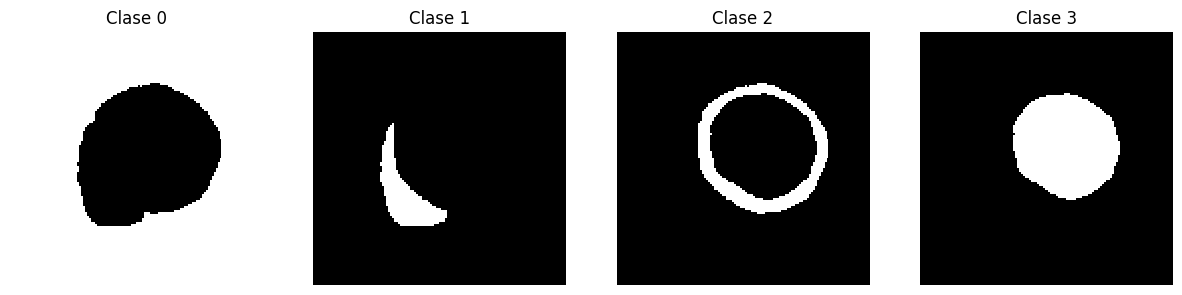

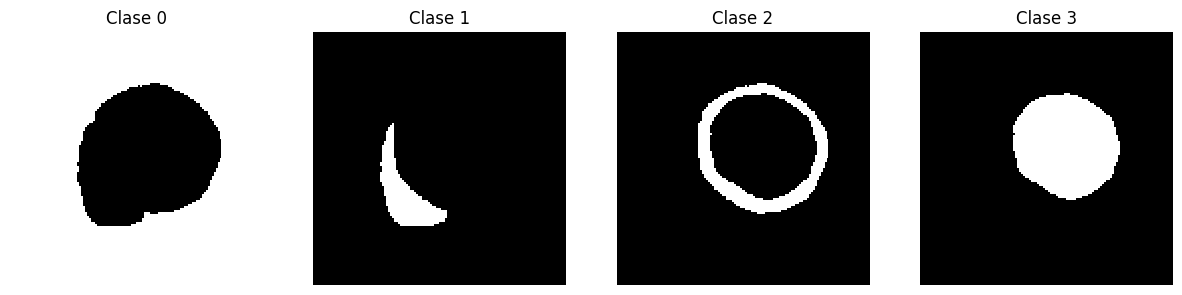

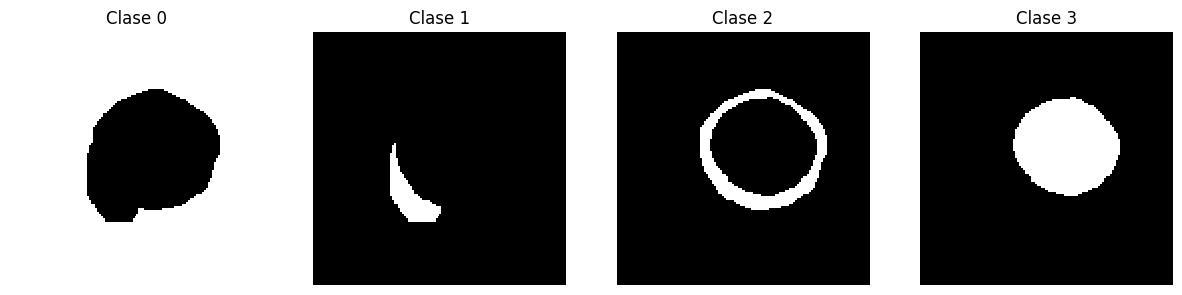

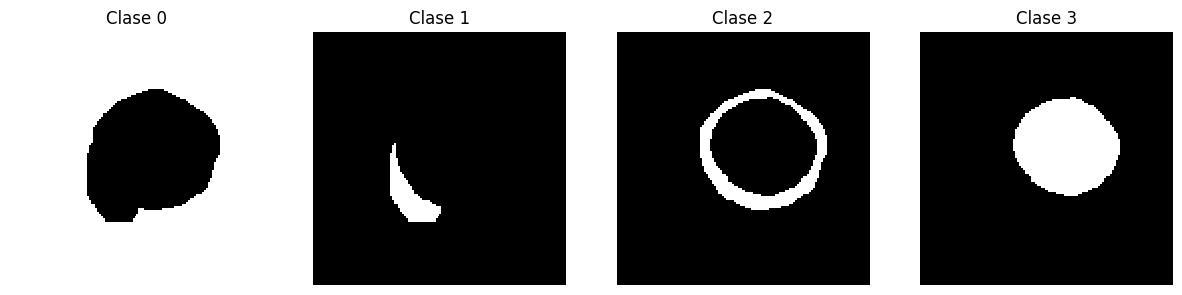

In [13]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [14]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=validation_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 24, 128, 128])
Image shape torch.Size([4, 24, 128, 128])


In [ ]:
# Get one batch of validation data to visualize
first(val_loader).__getitem__("image").shape

torch.Size([1, 4, 24, 128, 128])

In [16]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 24, 128, 128])


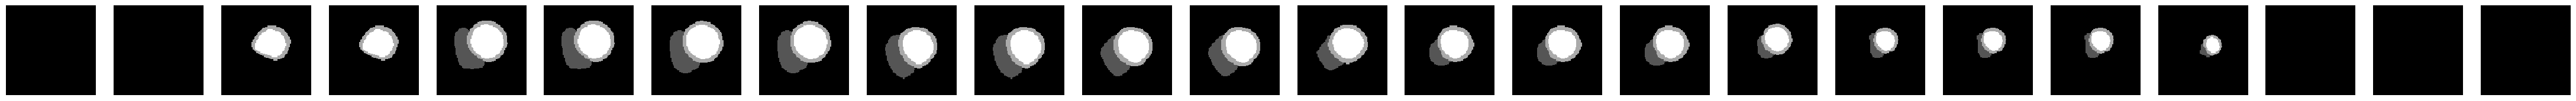

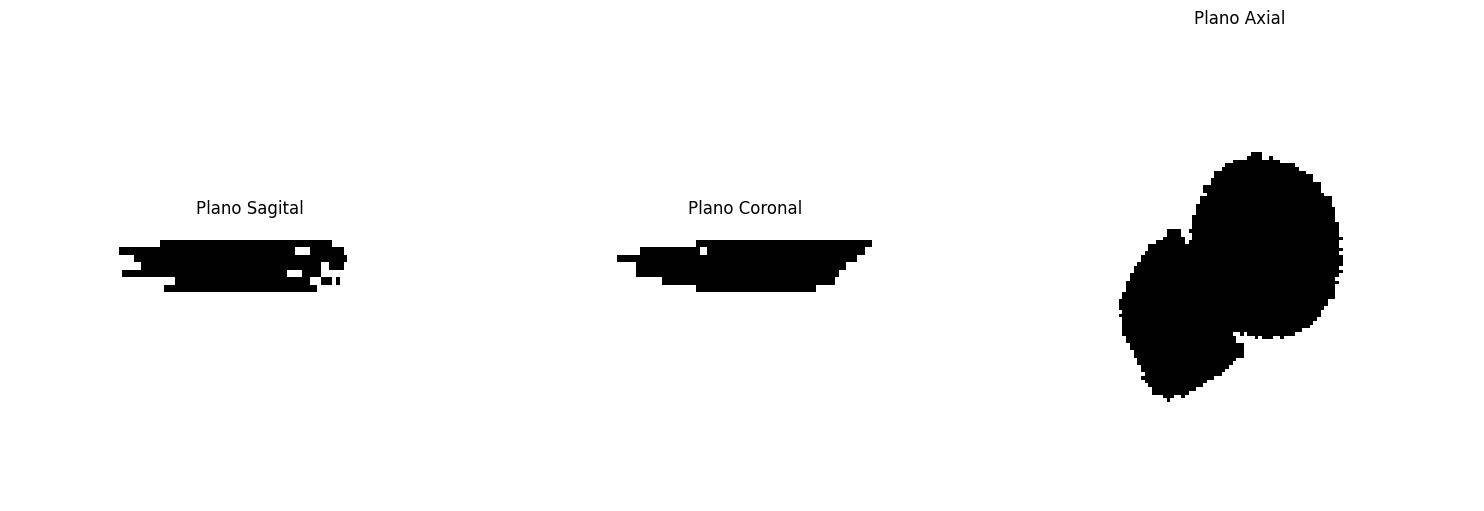

In [ ]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")


width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

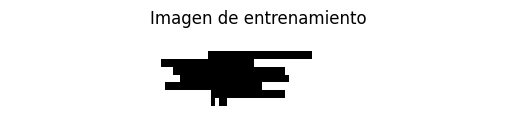

In [ ]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

Tamaño de la máscara cargada: torch.Size([1, 4, 24, 128, 128])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


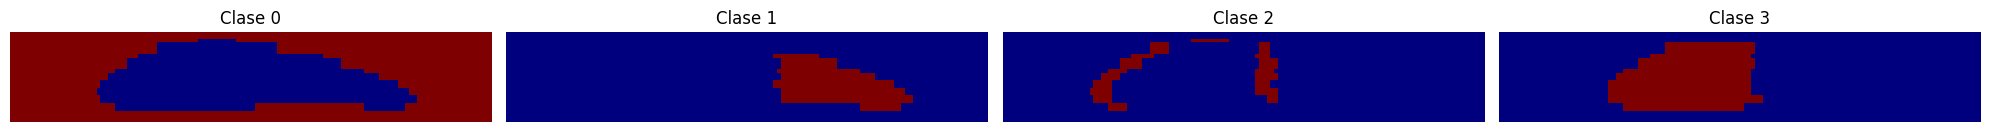

In [ ]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx] 

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


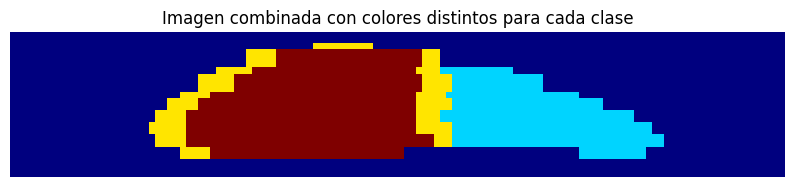

In [ ]:
# slice axial del tensor de imagen
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=2, padding=1),       # [4, 24, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=(1,1,1)),      # [16, 12, 64, 64] -> [16, 24, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 24, 128, 128] -> [4, 24, 128, 128]
        )

    
    def forward(self, x):
        # Encoder
        encoded = self.encoder(x) 
        flattened = encoded.view(encoded.size(0), -1)  
        latent_vector = self.fc[1](flattened) 
        fc_output = self.fc[2:](latent_vector) 

        # Decoder
        reshaped = fc_output.view(encoded.size()) 
        decoded = self.decoder(reshaped)

        return decoded, latent_vector 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 24, 128, 128).to(device) 
sample_output = model(sample_input)[0]
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 24, 128, 128])
Output shape: torch.Size([1, 4, 24, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [23]:
def save_latent_vectors(model, train_loader, val_loader, desc):
    train_latent_vectors = []
    val_latent_vectors = []

    with torch.no_grad():
        for batch_data in tqdm(train_loader, desc=f"Saving Train Latent Vectors ({desc})"):
            inputs = batch_data["image"].to(device)
            _, latent_vectors = model(inputs)
            train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

        for val_data in tqdm(val_loader, desc=f"Saving Validation Latent Vectors ({desc})"):
            val_inputs = val_data["image"].to(device)
            _, latent_vectors = model(val_inputs)
            val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

    train_latent_vectors = np.concatenate(train_latent_vectors, axis=0)
    val_latent_vectors = np.concatenate(val_latent_vectors, axis=0)

    return train_latent_vectors, val_latent_vectors

In [ ]:
from monai.metrics import DiceMetric, compute_hausdorff_distance

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()

num_epochs = 30
val_interval = 1
train_loss_list = []
val_loss_list = []
best_val_dice = 0
best_val_hausdorff = float('inf')

num_classes = 4
dice_metric = DiceMetric(include_background=False, reduction="none", get_not_nans=False)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    dice_metric.reset()

    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = batch_data["image"].to(device)
        outputs, train_latent_vectors_output = model(inputs)

        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        outputs_softmax = F.softmax(outputs, dim=1)
        outputs_one_hot = F.one_hot(torch.argmax(outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        dice_metric(y_pred=outputs_one_hot, y=inputs)

    dice_per_class = dice_metric.aggregate()
    avg_train_dice = dice_per_class.mean().item()

    hausdorff_distances_train = compute_hausdorff_distance(outputs_one_hot, inputs, include_background=False)
    avg_train_hausdorff = hausdorff_distances_train.mean().item()

    train_loss_list.append(train_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss_list[-1]:.4f}")
    print(f"  Train Dice: {avg_train_dice:.4f}")
    print(f"  Train Dice by Class: {dice_per_class.tolist()}")
    print(f"  Train Hausdorff: {avg_train_hausdorff:.4f}")
    print(f"  Train Hausdorff by Class: {hausdorff_distances_train.tolist()}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        dice_metric.reset()

        with torch.no_grad():
            for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_inputs = val_data["image"].to(device)
                val_outputs, val_latent_vectors_output = model(val_inputs)

                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

                val_outputs_softmax = F.softmax(val_outputs, dim=1)
                val_outputs_one_hot = F.one_hot(torch.argmax(val_outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
                dice_metric(y_pred=val_outputs_one_hot, y=val_inputs)

        dice_per_class_val = dice_metric.aggregate()
        avg_val_dice = dice_per_class_val.mean().item()
        
        hausdorff_distances_val = compute_hausdorff_distance(val_outputs_one_hot, val_inputs, include_background=False)
        avg_val_hausdorff = hausdorff_distances_val.mean().item()

        val_loss_list.append(val_loss / len(val_loader))

        print(f"  Validation Loss: {val_loss_list[-1]:.4f}")
        print(f"  Validation Dice: {avg_val_dice:.4f}")
        print(f"  Validation Dice by Class: {dice_per_class_val.tolist()}")
        print(f"  Validation Hausdorff: {avg_val_hausdorff:.4f}")
        print(f"  Validation Hausdorff by Class: {hausdorff_distances_val.tolist()}")

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Best Dice")

        if avg_val_hausdorff < best_val_hausdorff:
            best_val_hausdorff = avg_val_hausdorff
            best_train_latent_vectors_hausdorff, best_val_latent_vectors_hausdorff = save_latent_vectors(model, train_loader, val_loader, "Best Hausdorff")

last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

Epoch 1/30 [Train]: 100%|██████████| 1048/1048 [02:41<00:00,  6.50it/s]
monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.


Epoch [1/30]
  Train Loss: 0.2393
  Train Dice: 0.2195
  Train Dice by Class: [[0.04520047456026077, 0.07201236486434937, 0.04716699197888374], [0.017194360494613647, 0.058504898101091385, 0.019511092454195023], [0.0007062146905809641, 0.020714731886982918, 0.002358838217332959], [0.00014927600568626076, 0.003926187753677368, 7.617016672156751e-05], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.00018724838446360081, 0.0], [0.0, 0.0012610340490937233, 0.0], [0.0, 0.011405901052057743, 0.0], [0.0, 0.006495951674878597, 0.0], [0.0, 0.0015357612865045667, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]

Epoch 1/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.39it/s]


  Validation Loss: 0.2154
  Validation Dice: 0.4082
  Validation Dice by Class: [[0.3607965409755707, 0.1415157914161682, 0.6879392862319946], [0.1460248827934265, 0.41882047057151794, 0.7443994879722595], [0.1255372315645218, 0.06955727934837341, 0.6859062910079956], [0.5476041436195374, 0.17520858347415924, 0.7128755450248718], [0.5581737160682678, 0.3617021143436432, 0.7428444027900696], [0.2238902896642685, 0.055129650980234146, 0.0], [0.4388740062713623, 0.45474061369895935, 0.740693986415863], [0.06541129946708679, 0.10516620427370071, 0.6820074915885925], [0.1894758939743042, 0.31132927536964417, 0.44604167342185974], [0.3964678943157196, 0.12376829236745834, 0.681966245174408], [0.4653482437133789, 0.36676865816116333, 0.7243738770484924], [0.11272560060024261, 0.0713803693652153, 0.6706205010414124], [0.4473898112773895, 0.2607839107513428, 0.6924690008163452], [0.46762049198150635, 0.43131202459335327, 0.7645666003227234], [0.5053663849830627, 0.3204387426376343, 0.1131892949

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 1048/1048 [02:36<00:00,  6.68it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 612/612 [00:57<00:00, 10.64it/s]
Epoch 2/30 [Train]: 100%|██████████| 1048/1048 [02:38<00:00,  6.62it/s]


Epoch [2/30]
  Train Loss: 0.1694
  Train Dice: 0.5242
  Train Dice by Class: [[0.5098565816879272, 0.31925252079963684, 0.7347384691238403], [0.4791090488433838, 0.278058260679245, 0.7991113662719727], [0.3284059464931488, 0.3049350380897522, 0.7780418395996094], [0.49637681245803833, 0.30085715651512146, 0.635964572429657], [0.47819849848747253, 0.3643219769001007, 0.7808800935745239], [0.24577055871486664, 0.323420912027359, 0.7900723218917847], [0.24483917653560638, 0.2400936633348465, 0.5890945792198181], [0.3124903440475464, 0.16243094205856323, 0.6871209740638733], [0.499453604221344, 0.2680748701095581, 0.8164593577384949], [0.17390121519565582, 0.22116482257843018, 0.2572614252567291], [0.5362030863761902, 0.08920685201883316, 0.41613414883613586], [0.3542684018611908, 0.038508690893650055, 0.3757734000682831], [0.37468627095222473, 0.1617695838212967, 0.6514766216278076], [0.04269230738282204, 0.4493028223514557, 0.5462148785591125], [0.5156601071357727, 0.39821672439575195, 

Epoch 2/30 [Validation]: 100%|██████████| 612/612 [00:59<00:00, 10.23it/s]


  Validation Loss: 0.1797
  Validation Dice: 0.4445
  Validation Dice by Class: [[0.5781205296516418, 0.3242160975933075, 0.7691007852554321], [0.008342989720404148, 0.4797529876232147, 0.7627376914024353], [0.616877019405365, 0.2727028429508209, 0.7578715085983276], [0.5963190197944641, 0.3757271468639374, 0.815751850605011], [0.5068139433860779, 0.38994303345680237, 0.749229371547699], [0.2441421002149582, 0.08502914756536484, 0.0], [0.47152435779571533, 0.4404907524585724, 0.7508260011672974], [0.289284348487854, 0.18894600868225098, 0.7530518770217896], [0.1066179946064949, 0.29566091299057007, 0.5609080791473389], [0.5412203669548035, 0.362202525138855, 0.7856634855270386], [0.4423832595348358, 0.40546900033950806, 0.7731819152832031], [0.586604654788971, 0.3344792127609253, 0.7866523265838623], [0.5452163219451904, 0.38756871223449707, 0.7760276794433594], [0.512462854385376, 0.4302399158477783, 0.7922752499580383], [0.3805598318576813, 0.11955776065587997, 0.0], [0.5525050759315

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 1048/1048 [02:36<00:00,  6.68it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 612/612 [00:58<00:00, 10.47it/s]
Epoch 3/30 [Train]: 100%|██████████| 1048/1048 [02:37<00:00,  6.65it/s]


Epoch [3/30]
  Train Loss: 0.1563
  Train Dice: 0.5614
  Train Dice by Class: [[0.49027904868125916, 0.26311129331588745, 0.5168960690498352], [0.49496081471443176, 0.3605693280696869, 0.6599742770195007], [0.25901684165000916, 0.44617006182670593, 0.6628831028938293], [0.3213493227958679, 0.37431007623672485, 0.6384409666061401], [0.28652113676071167, 0.23468641936779022, 0.7173004150390625], [0.5148116946220398, 0.40955185890197754, 0.6584874391555786], [0.3459945321083069, 0.3266609013080597, 0.7658687829971313], [0.5083998441696167, 0.4416758418083191, 0.7985427975654602], [0.48835551738739014, 0.4016694724559784, 0.8545954823493958], [0.4997277557849884, 0.3959338963031769, 0.7505427598953247], [0.4231053590774536, 0.3837491571903229, 0.6716986894607544], [0.5349646210670471, 0.3702496290206909, 0.7733026742935181], [0.4346780776977539, 0.47444096207618713, 0.7504903674125671], [0.4721713066101074, 0.32408031821250916, 0.706291675567627], [0.5216179490089417, 0.4173091948032379, 0

Epoch 3/30 [Validation]: 100%|██████████| 612/612 [00:57<00:00, 10.58it/s]


  Validation Loss: 0.1798
  Validation Dice: 0.4514
  Validation Dice by Class: [[0.5029540061950684, 0.08396663516759872, 0.71222323179245], [0.0, 0.2934723198413849, 0.7211098670959473], [0.4954970180988312, 0.1376379430294037, 0.745555579662323], [0.6301652193069458, 0.23186543583869934, 0.7842099070549011], [0.5229334235191345, 0.22458124160766602, 0.7318969368934631], [0.3793369233608246, 0.38446879386901855, 0.5934651494026184], [0.31611546874046326, 0.23929542303085327, 0.701710045337677], [0.22655931115150452, 0.04644559323787689, 0.6874443292617798], [0.13026124238967896, 0.32669228315353394, 0.6188141107559204], [0.43791088461875916, 0.12650714814662933, 0.7289110422134399], [0.3968980014324188, 0.2214529663324356, 0.6948955655097961], [0.4956797659397125, 0.1507224291563034, 0.7192317247390747], [0.587180495262146, 0.2785065472126007, 0.728628933429718], [0.5172074437141418, 0.30461862683296204, 0.7290696501731873], [0.6088097095489502, 0.42813628911972046, 0.702686846256256

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 1048/1048 [02:37<00:00,  6.64it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 612/612 [00:58<00:00, 10.51it/s]
Epoch 4/30 [Train]: 100%|██████████| 1048/1048 [02:37<00:00,  6.67it/s]


Epoch [4/30]
  Train Loss: 0.1395
  Train Dice: 0.6130
  Train Dice by Class: [[0.5976934432983398, 0.3308349847793579, 0.7442066669464111], [0.751567542552948, 0.2969418466091156, 0.7504661083221436], [0.4593067169189453, 0.18681032955646515, 0.737490177154541], [0.4427790641784668, 0.3337332606315613, 0.6851522922515869], [0.6455966234207153, 0.23625746369361877, 0.7867754101753235], [0.5543647408485413, 0.36500880122184753, 0.6441794037818909], [0.6448935270309448, 0.3719458281993866, 0.7427532076835632], [0.5230518579483032, 0.16444166004657745, 0.7950990796089172], [0.540677547454834, 0.3906583786010742, 0.7599214911460876], [0.6365764141082764, 0.43811795115470886, 0.8068683743476868], [0.6767313480377197, 0.44903433322906494, 0.7228806614875793], [0.5560667514801025, 0.44575339555740356, 0.6386441588401794], [0.7201786637306213, 0.4015907645225525, 0.8237918615341187], [0.6198242902755737, 0.4823774993419647, 0.7577557563781738], [0.6428504586219788, 0.39162617921829224, 0.65724

Epoch 4/30 [Validation]: 100%|██████████| 612/612 [00:56<00:00, 10.74it/s]


  Validation Loss: 0.1696
  Validation Dice: 0.4919
  Validation Dice by Class: [[0.6148642897605896, 0.43796226382255554, 0.8404003977775574], [0.0, 0.4999315142631531, 0.763401210308075], [0.4498988687992096, 0.39007559418678284, 0.8194047212600708], [0.6710913181304932, 0.5604432821273804, 0.8491649627685547], [0.5763064622879028, 0.4129081666469574, 0.7820373177528381], [0.4910682737827301, 0.2306308001279831, 0.06902185082435608], [0.4609375, 0.5121176242828369, 0.7698005437850952], [0.4793820083141327, 0.2688322365283966, 0.7951578497886658], [0.18212701380252838, 0.3561992347240448, 0.5531202554702759], [0.5477985739707947, 0.4708735942840576, 0.8357642889022827], [0.5598487257957458, 0.5216752290725708, 0.8010005950927734], [0.5555821061134338, 0.5200033783912659, 0.8479865789413452], [0.6624627113342285, 0.5410019755363464, 0.8442230820655823], [0.56193608045578, 0.5665475130081177, 0.8251357674598694], [0.5748279094696045, 0.13968504965305328, 0.017941772937774658], [0.694135

Epoch 5/30 [Train]: 100%|██████████| 1048/1048 [02:38<00:00,  6.63it/s]


Epoch [5/30]
  Train Loss: 0.1207
  Train Dice: 0.6630
  Train Dice by Class: [[0.6405971050262451, 0.5909034609794617, 0.880239725112915], [0.6900076866149902, 0.5532125234603882, 0.877350926399231], [0.7962427139282227, 0.47724398970603943, 0.8571721911430359], [0.7403892278671265, 0.47336655855178833, 0.8291731476783752], [0.6646728515625, 0.40161818265914917, 0.6810320019721985], [0.6156960725784302, 0.5340203642845154, 0.711886465549469], [0.7403371930122375, 0.5684325098991394, 0.8244808912277222], [0.7438644170761108, 0.39656129479408264, 0.8087217807769775], [0.7584623694419861, 0.4118574261665344, 0.8049877285957336], [0.34124496579170227, 0.6034659743309021, 0.6433932185173035], [0.665930986404419, 0.45422983169555664, 0.7244898080825806], [0.7498969435691833, 0.47568896412849426, 0.8453654050827026], [0.620116651058197, 0.3992098271846771, 0.7646763920783997], [0.731718122959137, 0.4908042848110199, 0.8605080842971802], [0.6988759636878967, 0.5078005790710449, 0.883576691150

Epoch 5/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.52it/s]


  Validation Loss: 0.1625
  Validation Dice: 0.5618
  Validation Dice by Class: [[0.5486850738525391, 0.25768280029296875, 0.7711179852485657], [0.0, 0.4360012412071228, 0.7315478920936584], [0.6336285471916199, 0.40124276280403137, 0.8090086579322815], [0.7033398151397705, 0.47700774669647217, 0.8114880919456482], [0.6025425791740417, 0.3955164849758148, 0.7826532125473022], [0.6745840907096863, 0.6769487857818604, 0.7245275974273682], [0.4643715023994446, 0.35869118571281433, 0.7290408611297607], [0.5269697308540344, 0.2771628201007843, 0.7827897071838379], [0.4055023193359375, 0.522196888923645, 0.5372400879859924], [0.537784993648529, 0.3551027476787567, 0.7994920611381531], [0.4747863709926605, 0.3202744424343109, 0.7199599146842957], [0.5282009243965149, 0.4162522852420807, 0.7922530174255371], [0.5949465036392212, 0.4076419174671173, 0.7787836790084839], [0.4530524015426636, 0.43382248282432556, 0.7325763702392578], [0.7847208380699158, 0.6309400200843811, 0.7151340842247009], [

Epoch 6/30 [Train]: 100%|██████████| 1048/1048 [02:39<00:00,  6.57it/s]


Epoch [6/30]
  Train Loss: 0.1188
  Train Dice: 0.6687
  Train Dice by Class: [[0.6158440113067627, 0.5795102119445801, 0.8324177265167236], [0.6705090999603271, 0.6247557401657104, 0.7780152559280396], [0.6975576877593994, 0.6373982429504395, 0.8056293725967407], [0.00730816088616848, 0.6452822685241699, 0.7337386608123779], [0.6725663542747498, 0.58973228931427, 0.8548358082771301], [0.4830019176006317, 0.6613834500312805, 0.6662847995758057], [0.5523433089256287, 0.6851133704185486, 0.7731360197067261], [0.6859195828437805, 0.6876429319381714, 0.7763246893882751], [0.5452127456665039, 0.5958775877952576, 0.5822102427482605], [0.6392748355865479, 0.6944553852081299, 0.9208760261535645], [0.5211838483810425, 0.5095710754394531, 0.7910089492797852], [0.5915402173995972, 0.4789378345012665, 0.7288635969161987], [0.7377870678901672, 0.5107461810112, 0.8305674195289612], [0.7316536903381348, 0.5040131211280823, 0.8401133418083191], [0.5638003349304199, 0.6131349802017212, 0.76531404256820

Epoch 6/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.53it/s]


  Validation Loss: 0.1783
  Validation Dice: 0.5288
  Validation Dice by Class: [[0.6109045743942261, 0.2014772891998291, 0.7664691209793091], [0.0, 0.4039134383201599, 0.7121702432632446], [0.6185399293899536, 0.4693247973918915, 0.8550536036491394], [0.7752397060394287, 0.5447872281074524, 0.8478150963783264], [0.6319765448570251, 0.43243715167045593, 0.7981827855110168], [0.6950275897979736, 0.6726639270782471, 0.7915173172950745], [0.17534247040748596, 0.35447803139686584, 0.7120628356933594], [0.4773881435394287, 0.18475483357906342, 0.7664287090301514], [0.44463035464286804, 0.4916844964027405, 0.4204309284687042], [0.5367004871368408, 0.3259434103965759, 0.7846928238868713], [0.4756488800048828, 0.2915312349796295, 0.6890890598297119], [0.5871081948280334, 0.26818475127220154, 0.7533263564109802], [0.6816930770874023, 0.3999389410018921, 0.781995952129364], [0.546118974685669, 0.4546077251434326, 0.7310120463371277], [0.7562230825424194, 0.6498982310295105, 0.7022332549095154], 

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 1048/1048 [02:40<00:00,  6.54it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 612/612 [00:58<00:00, 10.46it/s]
Epoch 7/30 [Train]: 100%|██████████| 1048/1048 [02:37<00:00,  6.66it/s]


Epoch [7/30]
  Train Loss: 0.1140
  Train Dice: 0.6798
  Train Dice by Class: [[0.7265254855155945, 0.2905316650867462, 0.8263327479362488], [0.735660195350647, 0.6554739475250244, 0.7649000287055969], [0.559274435043335, 0.6694242358207703, 0.7022538781166077], [0.6564854979515076, 0.5942849516868591, 0.7981719374656677], [0.5546021461486816, 0.4937434494495392, 0.7739717364311218], [0.6730519533157349, 0.6612943410873413, 0.8464779853820801], [0.7200797200202942, 0.4748052656650543, 0.814208447933197], [0.5934258699417114, 0.42978018522262573, 0.7943078279495239], [0.7376906871795654, 0.5639983415603638, 0.7798169255256653], [0.8039441108703613, 0.759293258190155, 0.7718128561973572], [0.7384652495384216, 0.47940725088119507, 0.78138667345047], [0.6537600159645081, 0.6975477933883667, 0.8918043971061707], [0.8122833967208862, 0.6801066994667053, 0.8277100920677185], [0.7622815370559692, 0.631588339805603, 0.7705667614936829], [0.647742509841919, 0.6733866333961487, 0.771626889705658]

Epoch 7/30 [Validation]: 100%|██████████| 612/612 [00:59<00:00, 10.37it/s]


  Validation Loss: 0.1630
  Validation Dice: 0.5453
  Validation Dice by Class: [[0.5716771483421326, 0.2735471725463867, 0.7751563191413879], [0.0, 0.4356372058391571, 0.7181940078735352], [0.5849563479423523, 0.36796316504478455, 0.8136211037635803], [0.6792044639587402, 0.4901452958583832, 0.8282802700996399], [0.6131493449211121, 0.38473060727119446, 0.777702271938324], [0.7216933965682983, 0.744096577167511, 0.8084322810173035], [0.4645378887653351, 0.3870488703250885, 0.7216002345085144], [0.4038349390029907, 0.235480397939682, 0.7686631083488464], [0.3316493630409241, 0.5012518167495728, 0.5014328956604004], [0.5313970446586609, 0.3207165002822876, 0.7903549075126648], [0.5639227032661438, 0.35324418544769287, 0.7236353754997253], [0.6204620599746704, 0.40649017691612244, 0.7980386018753052], [0.5814558863639832, 0.3812907040119171, 0.7763851881027222], [0.43212375044822693, 0.4154049754142761, 0.7312132120132446], [0.8140644431114197, 0.7072855830192566, 0.7528923153877258], [0

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 1048/1048 [02:39<00:00,  6.57it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 612/612 [00:59<00:00, 10.33it/s]
Epoch 8/30 [Train]: 100%|██████████| 1048/1048 [02:39<00:00,  6.59it/s]


Epoch [8/30]
  Train Loss: 0.1135
  Train Dice: 0.6815
  Train Dice by Class: [[0.551856279373169, 0.6765997409820557, 0.7027499079704285], [0.7348439693450928, 0.6636208295822144, 0.820231556892395], [0.5652580857276917, 0.3241904079914093, 0.765943169593811], [0.6044342517852783, 0.6557292938232422, 0.8261216282844543], [0.7575232982635498, 0.5890646576881409, 0.6923438906669617], [0.7695473432540894, 0.664391040802002, 0.8720554113388062], [0.5400959849357605, 0.6762073636054993, 0.7217630743980408], [0.6871557831764221, 0.6364189982414246, 0.7434960603713989], [0.7127255797386169, 0.559533417224884, 0.7890514135360718], [0.726727306842804, 0.5115463733673096, 0.8372363448143005], [0.6866320967674255, 0.563025951385498, 0.8582639694213867], [0.7364533543586731, 0.5820590853691101, 0.8837258815765381], [0.6531668901443481, 0.699999988079071, 0.7354182004928589], [0.7083717584609985, 0.6931363344192505, 0.8243521451950073], [0.5625286102294922, 0.44853806495666504, 0.00674432842060923

Epoch 8/30 [Validation]: 100%|██████████| 612/612 [00:57<00:00, 10.56it/s]


  Validation Loss: 0.1696
  Validation Dice: 0.5244
  Validation Dice by Class: [[0.7144495248794556, 0.478312611579895, 0.8377363085746765], [0.0, 0.5870839357376099, 0.7813563942909241], [0.6475270390510559, 0.4414098262786865, 0.8370495438575745], [0.7455953359603882, 0.6771695017814636, 0.8541439771652222], [0.6576669812202454, 0.5568021535873413, 0.8185319304466248], [0.5452035665512085, 0.3618296980857849, 0.1256689727306366], [0.6070431470870972, 0.5325965881347656, 0.7598456740379333], [0.4981386661529541, 0.3800309896469116, 0.8293550610542297], [0.3523435890674591, 0.5389128923416138, 0.5571229457855225], [0.6259881854057312, 0.4949513375759125, 0.8361807465553284], [0.6768642663955688, 0.5516892671585083, 0.7841225862503052], [0.7469300031661987, 0.5516872406005859, 0.8397004008293152], [0.6868822574615479, 0.6466509103775024, 0.8642322421073914], [0.6005264520645142, 0.6436328887939453, 0.8020140528678894], [0.6693931221961975, 0.20126330852508545, 0.002044293098151684], [0

Epoch 9/30 [Train]: 100%|██████████| 1048/1048 [02:40<00:00,  6.54it/s]


Epoch [9/30]
  Train Loss: 0.1082
  Train Dice: 0.6924
  Train Dice by Class: [[0.5656697750091553, 0.5096404552459717, 0.8342124819755554], [0.6786470413208008, 0.7014087438583374, 0.8393594026565552], [0.7735654711723328, 0.6145287752151489, 0.8044418692588806], [0.7172085642814636, 0.5367155075073242, 0.782702624797821], [0.7661290168762207, 0.7066739797592163, 0.6956411600112915], [0.668617844581604, 0.738593339920044, 0.8519902229309082], [0.8052831888198853, 0.5050808787345886, 0.8488405346870422], [0.7552013397216797, 0.6460989117622375, 0.8911410570144653], [0.7913172245025635, 0.5598841905593872, 0.8825560212135315], [0.7351371049880981, 0.6240832805633545, 0.8857865333557129], [0.7034262418746948, 0.6012879610061646, 0.7885729074478149], [0.7609268426895142, 0.6058945655822754, 0.5079365372657776], [0.6877915859222412, 0.5149092078208923, 0.7614071369171143], [0.6996881365776062, 0.5650914311408997, 0.8009782433509827], [0.45119011402130127, 0.5123909115791321, 0.675197303295

Epoch 9/30 [Validation]: 100%|██████████| 612/612 [00:59<00:00, 10.23it/s]


  Validation Loss: 0.1318
  Validation Dice: 0.5732
  Validation Dice by Class: [[0.7514142990112305, 0.4716799855232239, 0.8423208594322205], [0.14962805807590485, 0.5575692653656006, 0.796546995639801], [0.6146369576454163, 0.3379019498825073, 0.7809878587722778], [0.7709002494812012, 0.54935622215271, 0.8437725305557251], [0.7147753238677979, 0.4789184331893921, 0.798552393913269], [0.6561875343322754, 0.527385413646698, 0.6493074893951416], [0.7502372860908508, 0.5078718662261963, 0.7641516327857971], [0.6080319881439209, 0.4702669382095337, 0.8491935133934021], [0.4401301443576813, 0.5143308639526367, 0.6213855743408203], [0.7064811587333679, 0.4500863552093506, 0.8135794401168823], [0.7491631507873535, 0.5105107426643372, 0.7742542028427124], [0.7288732528686523, 0.5634276866912842, 0.8684202432632446], [0.7234525084495544, 0.530701756477356, 0.8474745750427246], [0.6719515919685364, 0.5554462671279907, 0.794845461845398], [0.705963134765625, 0.29577216506004333, 0.09419000148773

Epoch 10/30 [Train]: 100%|██████████| 1048/1048 [02:53<00:00,  6.05it/s]


Epoch [10/30]
  Train Loss: 0.1084
  Train Dice: 0.6958
  Train Dice by Class: [[0.664124608039856, 0.4586942493915558, 0.7606871128082275], [0.7044538855552673, 0.5925925970077515, 0.8656258583068848], [0.7763440012931824, 0.5646581649780273, 0.8936018943786621], [0.6601163148880005, 0.5058246850967407, 0.8547990918159485], [0.795735239982605, 0.7030806541442871, 0.8465377688407898], [0.7579987645149231, 0.6421797275543213, 0.8009248971939087], [0.7154794335365295, 0.6654486656188965, 0.7460429668426514], [0.5114619135856628, 0.6857801675796509, 0.7858174443244934], [0.7702619433403015, 0.5852873921394348, 0.845704972743988], [0.748651921749115, 0.5908857583999634, 0.8731130361557007], [0.5924291014671326, 0.6456632614135742, 0.7934197187423706], [0.7508489489555359, 0.5402621626853943, 0.7767038941383362], [0.5290428996086121, 0.6650652289390564, 0.6484711766242981], [0.6474500894546509, 0.38678887486457825, 0.8175176382064819], [0.749390184879303, 0.6648343205451965, 0.7992708683013

Epoch 10/30 [Validation]: 100%|██████████| 612/612 [00:59<00:00, 10.37it/s]


  Validation Loss: 0.1568
  Validation Dice: 0.5320
  Validation Dice by Class: [[0.7302173972129822, 0.4993589222431183, 0.8457247018814087], [0.0, 0.6658034920692444, 0.8157137632369995], [0.6773342490196228, 0.4864669442176819, 0.8502601981163025], [0.8298102021217346, 0.6749969124794006, 0.8649567365646362], [0.7439791560173035, 0.6073911786079407, 0.8395327925682068], [0.6521621942520142, 0.5209295153617859, 0.3191186785697937], [0.6481989622116089, 0.5943683981895447, 0.7585946321487427], [0.5253012180328369, 0.32227233052253723, 0.8151657581329346], [0.6301179528236389, 0.6037458777427673, 0.5259721279144287], [0.7051432728767395, 0.5593314170837402, 0.8470746874809265], [0.7350689172744751, 0.6175287961959839, 0.7939938306808472], [0.7095024585723877, 0.5710299015045166, 0.8412314057350159], [0.7883334755897522, 0.6497756838798523, 0.8691061735153198], [0.6894468665122986, 0.6361607909202576, 0.803801953792572], [0.6367343664169312, 0.27804961800575256, 0.0], [0.751731753349304

Epoch 11/30 [Train]: 100%|██████████| 1048/1048 [02:52<00:00,  6.07it/s]


Epoch [11/30]
  Train Loss: 0.1051
  Train Dice: 0.7020
  Train Dice by Class: [[0.7786462903022766, 0.7377936840057373, 0.8939907550811768], [0.7351067066192627, 0.7687929272651672, 0.7826723456382751], [0.6814860105514526, 0.5055122375488281, 0.8165832161903381], [0.7129523754119873, 0.6434310674667358, 0.7850890159606934], [0.515662670135498, 0.7500569224357605, 0.6542983651161194], [0.7710777521133423, 0.6272309422492981, 0.8675583004951477], [0.5381612777709961, 0.6987190842628479, 0.8296371698379517], [0.695564329624176, 0.6499894857406616, 0.8442844748497009], [0.6951165199279785, 0.6190789937973022, 0.7760208249092102], [0.6316297650337219, 0.6516140699386597, 0.8326870203018188], [0.8147327899932861, 0.6138733625411987, 0.850038468837738], [0.641093909740448, 0.5579574704170227, 0.6524232625961304], [0.5959193706512451, 0.7193570733070374, 0.7685579061508179], [0.7821270227432251, 0.5335685014724731, 0.8853394985198975], [0.760993480682373, 0.7274829149246216, 0.80432164669036

Epoch 11/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.49it/s]


  Validation Loss: 0.1736
  Validation Dice: 0.5267
  Validation Dice by Class: [[0.48045092821121216, 0.1657581627368927, 0.7276749610900879], [0.037155963480472565, 0.398068904876709, 0.695671796798706], [0.5798935890197754, 0.272743821144104, 0.7910701632499695], [0.5565040707588196, 0.25710561871528625, 0.7746977806091309], [0.5785636305809021, 0.3030540943145752, 0.7173622250556946], [0.6525676250457764, 0.622114896774292, 0.6823801398277283], [0.5520275235176086, 0.340271919965744, 0.691195011138916], [0.23871129751205444, 0.12497041374444962, 0.7221755981445312], [0.3344268202781677, 0.3297594487667084, 0.3062939941883087], [0.5352252125740051, 0.3135938048362732, 0.7545560002326965], [0.5145050287246704, 0.2945261299610138, 0.6641924977302551], [0.34974074363708496, 0.18124064803123474, 0.7127847075462341], [0.48752254247665405, 0.20840197801589966, 0.7083830833435059], [0.285066157579422, 0.3349371552467346, 0.6893520951271057], [0.7875413298606873, 0.6971070170402527, 0.80990

Epoch 12/30 [Train]: 100%|██████████| 1048/1048 [02:53<00:00,  6.04it/s]


Epoch [12/30]
  Train Loss: 0.1042
  Train Dice: 0.7053
  Train Dice by Class: [[0.7297892570495605, 0.739922046661377, 0.7509979009628296], [0.7661703824996948, 0.6366075277328491, 0.8585013747215271], [0.6881690621376038, 0.6391406059265137, 0.7940744161605835], [0.38471731543540955, 0.5367516279220581, 0.5605966448783875], [0.3744003176689148, 0.41943952441215515, 0.7404698729515076], [0.8316693902015686, 0.5711122751235962, 0.8663792014122009], [0.6783174276351929, 0.658393383026123, 0.8214951157569885], [0.6582390069961548, 0.5247834920883179, 0.8389730453491211], [0.7411770820617676, 0.6200072169303894, 0.8509784936904907], [0.6257596015930176, 0.6462804079055786, 0.8048400282859802], [0.6317921876907349, 0.5921493768692017, 0.750123143196106], [0.7998195886611938, 0.5780148506164551, 0.8170951008796692], [0.8088939189910889, 0.5798264145851135, 0.8833438754081726], [0.6783843636512756, 0.7050359845161438, 0.7685437798500061], [0.776520848274231, 0.6859786510467529, 0.86434829235

Epoch 12/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.48it/s]


  Validation Loss: 0.2040
  Validation Dice: 0.4945
  Validation Dice by Class: [[0.6017347574234009, 0.21398617327213287, 0.7692577242851257], [0.02673427015542984, 0.5451454520225525, 0.7445459365844727], [0.605928897857666, 0.33184394240379333, 0.8383477330207825], [0.6603379845619202, 0.35954153537750244, 0.8275423645973206], [0.6264698505401611, 0.41066908836364746, 0.7755089402198792], [0.7209473848342896, 0.6447373628616333, 0.7328028082847595], [0.6476225852966309, 0.42598870396614075, 0.7107985615730286], [0.3972925841808319, 0.23138117790222168, 0.7864251136779785], [0.5598123669624329, 0.46632301807403564, 0.35438433289527893], [0.6094651818275452, 0.3594614267349243, 0.780400276184082], [0.6253952383995056, 0.3667571246623993, 0.6866026520729065], [0.5783342719078064, 0.25869277119636536, 0.7533693909645081], [0.6066097021102905, 0.4329201281070709, 0.792197585105896], [0.5126037001609802, 0.5278264284133911, 0.7434239387512207], [0.7814168930053711, 0.6557449698448181, 0.7

Epoch 13/30 [Train]: 100%|██████████| 1048/1048 [02:53<00:00,  6.04it/s]


Epoch [13/30]
  Train Loss: 0.1005
  Train Dice: 0.7112
  Train Dice by Class: [[0.7599681615829468, 0.6554708480834961, 0.8825977444648743], [0.5496228337287903, 0.6288774609565735, 0.8979771137237549], [0.6756675839424133, 0.6661121249198914, 0.7728747129440308], [0.7536783218383789, 0.5389001369476318, 0.8397945761680603], [0.8009433150291443, 0.4394741356372833, 0.7991052865982056], [0.5598567128181458, 0.7193078994750977, 0.7014498710632324], [0.6357066631317139, 0.5814698934555054, 0.8007081151008606], [0.6289926171302795, 0.6826841831207275, 0.7828566431999207], [0.7036135792732239, 0.6582040786743164, 0.8898789286613464], [0.649915874004364, 0.5809849500656128, 0.8705993890762329], [0.647171676158905, 0.59363853931427, 0.6285589337348938], [0.7318733930587769, 0.6362124085426331, 0.9112766981124878], [0.7141132354736328, 0.7976872324943542, 0.8348328471183777], [0.8025636672973633, 0.5827191472053528, 0.9138072729110718], [0.6863530278205872, 0.5942350625991821, 0.7667952775955

Epoch 13/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.52it/s]


  Validation Loss: 0.1632
  Validation Dice: 0.5168
  Validation Dice by Class: [[0.676381528377533, 0.496785968542099, 0.8241278529167175], [0.01714947819709778, 0.5837122201919556, 0.8245471715927124], [0.6153377890586853, 0.47360649704933167, 0.8389106392860413], [0.7220621705055237, 0.5147810578346252, 0.8228465914726257], [0.6018320918083191, 0.47129741311073303, 0.7574779391288757], [0.43394625186920166, 0.12933048605918884, 0.0], [0.5044394731521606, 0.5207955241203308, 0.724916934967041], [0.512525200843811, 0.5205198526382446, 0.8409218192100525], [0.31622952222824097, 0.48203447461128235, 0.5705609321594238], [0.5782801508903503, 0.4946151375770569, 0.8202383518218994], [0.5216134190559387, 0.5191711783409119, 0.7566806077957153], [0.6984456181526184, 0.5753365159034729, 0.8546233773231506], [0.6097579598426819, 0.5482752919197083, 0.8204112648963928], [0.4931449890136719, 0.45747509598731995, 0.7535842061042786], [0.5252627730369568, 0.06934937834739685, 0.0], [0.64324235916

Epoch 14/30 [Train]: 100%|██████████| 1048/1048 [02:57<00:00,  5.91it/s]


Epoch [14/30]
  Train Loss: 0.1005
  Train Dice: 0.7140
  Train Dice by Class: [[0.6593538522720337, 0.4609130322933197, 0.7839049100875854], [0.7989856004714966, 0.5386176109313965, 0.8471838235855103], [0.7050893902778625, 0.6746945381164551, 0.7520861625671387], [0.7976842522621155, 0.6478644013404846, 0.7343505024909973], [0.6681520938873291, 0.5675209164619446, 0.7712268829345703], [0.7892215847969055, 0.6987119913101196, 0.846441924571991], [0.6312136054039001, 0.7252580523490906, 0.7953926920890808], [0.7388296723365784, 0.5779544711112976, 0.7652585506439209], [0.6276310682296753, 0.4965880811214447, 0.6644586324691772], [0.7248567342758179, 0.5982893705368042, 0.7964005470275879], [0.7294952869415283, 0.6431100964546204, 0.8735103607177734], [0.737821102142334, 0.46436840295791626, 0.8592631220817566], [0.49279680848121643, 0.7439470887184143, 0.9035746455192566], [0.6900556087493896, 0.566430389881134, 0.8440900444984436], [0.7543583512306213, 0.6845656633377075, 0.8250704407

Epoch 14/30 [Validation]: 100%|██████████| 612/612 [01:00<00:00, 10.08it/s]
the prediction of class 2 is all 0, this may result in nan/inf distance.


  Validation Loss: 0.1904
  Validation Dice: 0.4501
  Validation Dice by Class: [[0.7499555945396423, 0.4530177414417267, 0.7812153697013855], [0.2885017395019531, 0.438286691904068, 0.5292220711708069], [0.6668195128440857, 0.15813015401363373, 0.5882814526557922], [0.7968666553497314, 0.5059806108474731, 0.7216561436653137], [0.7162193655967712, 0.4399719536304474, 0.6174057722091675], [0.47931763529777527, 0.03570396825671196, 0.0], [0.5435953140258789, 0.36742764711380005, 0.42442643642425537], [0.682243824005127, 0.5971571803092957, 0.8593711853027344], [0.5192396640777588, 0.5722104907035828, 0.4747094511985779], [0.638610303401947, 0.41156965494155884, 0.6523374915122986], [0.6221634149551392, 0.4519980847835541, 0.5232558250427246], [0.6879269480705261, 0.6557720899581909, 0.8826058506965637], [0.718300998210907, 0.5569291114807129, 0.7755177021026611], [0.5733951926231384, 0.4259280562400818, 0.5332211852073669], [0.4937390685081482, 0.010236366651952267, 0.0], [0.603195011615

Epoch 15/30 [Train]: 100%|██████████| 1048/1048 [02:59<00:00,  5.83it/s]


Epoch [15/30]
  Train Loss: 0.1004
  Train Dice: 0.7158
  Train Dice by Class: [[0.7551780343055725, 0.6641364097595215, 0.895256757736206], [0.7706308960914612, 0.5946895480155945, 0.866731584072113], [0.8252859711647034, 0.6310951113700867, 0.861842930316925], [0.6079826354980469, 0.6197662353515625, 0.8559630513191223], [0.7976981997489929, 0.6085999011993408, 0.899404764175415], [0.7853556275367737, 0.5760828852653503, 0.8575639128684998], [0.5686600208282471, 0.674455463886261, 0.7085626721382141], [0.8117176294326782, 0.6233940124511719, 0.7732954621315002], [0.7704542279243469, 0.6382777094841003, 0.8010732531547546], [0.813153862953186, 0.6891369223594666, 0.8150539994239807], [0.7835015654563904, 0.6350611448287964, 0.9043870568275452], [0.8630116581916809, 0.5546749830245972, 0.8722410798072815], [0.6901916861534119, 0.6450403332710266, 0.7501774430274963], [0.6903027296066284, 0.7538273930549622, 0.8370711803436279], [0.5942352414131165, 0.6802495718002319, 0.732016742229461

Epoch 15/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.38it/s]


  Validation Loss: 0.1669
  Validation Dice: 0.5123
  Validation Dice by Class: [[0.7591391801834106, 0.5585685968399048, 0.865350604057312], [0.341717004776001, 0.48538845777511597, 0.7181111574172974], [0.7050697803497314, 0.5023329257965088, 0.8385605812072754], [0.777576208114624, 0.713325023651123, 0.8759692311286926], [0.7060455083847046, 0.5070103406906128, 0.7795516848564148], [0.5718308687210083, 0.2653390169143677, 0.23082678020000458], [0.7082301378250122, 0.48951786756515503, 0.6916588544845581], [0.6265920996665955, 0.578179121017456, 0.8799380660057068], [0.5208293199539185, 0.5563077330589294, 0.48507577180862427], [0.7047712802886963, 0.5592197179794312, 0.8493978977203369], [0.7245436310768127, 0.5291303396224976, 0.7064832448959351], [0.7340698838233948, 0.662832498550415, 0.8786354064941406], [0.7118862271308899, 0.6164057850837708, 0.84568852186203], [0.6222122311592102, 0.47559458017349243, 0.6854538917541504], [0.5654672980308533, 0.09598603844642639, 0.0221253763

Epoch 16/30 [Train]: 100%|██████████| 1048/1048 [02:55<00:00,  5.96it/s]


Epoch [16/30]
  Train Loss: 0.0972
  Train Dice: 0.7203
  Train Dice by Class: [[0.6859879493713379, 0.581126868724823, 0.7225494384765625], [0.6325751543045044, 0.6854441165924072, 0.8348289132118225], [0.6164050102233887, 0.6389878392219543, 0.6904181241989136], [0.21732138097286224, 0.6635727882385254, 0.7488071322441101], [0.6840958595275879, 0.727400541305542, 0.6819484233856201], [0.705498993396759, 0.6700195670127869, 0.8228772878646851], [0.7091146111488342, 0.6273095011711121, 0.7134203314781189], [0.4266567528247833, 0.6408215165138245, 0.7220824360847473], [0.632013201713562, 0.4944747984409332, 0.818489134311676], [0.7383148670196533, 0.48204296827316284, 0.8509166836738586], [0.7879896759986877, 0.5059319138526917, 0.8134768605232239], [0.825960099697113, 0.6586495041847229, 0.8774741291999817], [0.7009774446487427, 0.7102421522140503, 0.8365496397018433], [0.7196705937385559, 0.6472848057746887, 0.7576786875724792], [0.7141501307487488, 0.599587619304657, 0.78209435939788

Epoch 16/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.50it/s]


  Validation Loss: 0.1627
  Validation Dice: 0.5726
  Validation Dice by Class: [[0.7036011219024658, 0.4542520344257355, 0.8358907103538513], [0.05847688019275665, 0.6374771595001221, 0.803534746170044], [0.7090607285499573, 0.4946322739124298, 0.843730628490448], [0.7979518175125122, 0.69640052318573, 0.8995727896690369], [0.7125492691993713, 0.6037614941596985, 0.8277881145477295], [0.699741542339325, 0.6295446157455444, 0.7391088008880615], [0.6736937165260315, 0.5868667960166931, 0.768455445766449], [0.5968505144119263, 0.49789464473724365, 0.8598487973213196], [0.5760469436645508, 0.5720409750938416, 0.4331215023994446], [0.6867392659187317, 0.5811840295791626, 0.8560492992401123], [0.6537178158760071, 0.623929500579834, 0.783427894115448], [0.6988409161567688, 0.5251879096031189, 0.8314071893692017], [0.741513192653656, 0.6380331516265869, 0.8560211658477783], [0.6457051038742065, 0.626552939414978, 0.7864177823066711], [0.7346970438957214, 0.42355242371559143, 0.400105148553848

Epoch 17/30 [Train]: 100%|██████████| 1048/1048 [02:52<00:00,  6.08it/s]


Epoch [17/30]
  Train Loss: 0.0963
  Train Dice: 0.7248
  Train Dice by Class: [[0.7297009825706482, 0.5750759840011597, 0.7391723990440369], [0.743522047996521, 0.5436080098152161, 0.7640513181686401], [0.8092409372329712, 0.6618365049362183, 0.8834819793701172], [0.6752863526344299, 0.7208541035652161, 0.7609108090400696], [0.6900886297225952, 0.7298711538314819, 0.7097893357276917], [0.6483891010284424, 0.6525540947914124, 0.8260276913642883], [0.5690157413482666, 0.6700605154037476, 0.8210124969482422], [0.7288456559181213, 0.46296459436416626, 0.8043738603591919], [0.7927917242050171, 0.7833222150802612, 0.8290865421295166], [0.6336765885353088, 0.6009781360626221, 0.7367252111434937], [0.7704463601112366, 0.673675537109375, 0.7519364953041077], [0.8096600770950317, 0.5540065765380859, 0.8650162220001221], [0.7172434329986572, 0.7887120842933655, 0.7184466123580933], [0.6426599621772766, 0.6915707588195801, 0.8461260795593262], [0.5631440877914429, 0.7106974720954895, 0.7188223600

Epoch 17/30 [Validation]: 100%|██████████| 612/612 [00:58<00:00, 10.48it/s]


  Validation Loss: 0.2025
  Validation Dice: 0.4547
  Validation Dice by Class: [[0.7797512412071228, 0.46710601449012756, 0.802665650844574], [0.2480829954147339, 0.43952471017837524, 0.6572207808494568], [0.6601526737213135, 0.2019120156764984, 0.6611931920051575], [0.7965101599693298, 0.4075089991092682, 0.7290250062942505], [0.6972675323486328, 0.35039713978767395, 0.6491057276725769], [0.45896682143211365, 0.09295161068439484, 0.02299811877310276], [0.633176326751709, 0.4120648205280304, 0.5706772804260254], [0.5595608949661255, 0.5275506973266602, 0.8407695889472961], [0.48149818181991577, 0.5084003806114197, 0.47867482900619507], [0.7019214630126953, 0.37335675954818726, 0.6862974762916565], [0.613077700138092, 0.33754628896713257, 0.515795886516571], [0.7363961338996887, 0.6766924858093262, 0.9000835418701172], [0.6576545834541321, 0.4867183566093445, 0.7797256708145142], [0.5290645956993103, 0.4258561432361603, 0.6545084118843079], [0.46548980474472046, 0.0072409952990710735, 

Epoch 18/30 [Train]: 100%|██████████| 1048/1048 [02:58<00:00,  5.85it/s]


Epoch [18/30]
  Train Loss: 0.0954
  Train Dice: 0.7263
  Train Dice by Class: [[0.7237663865089417, 0.6648372411727905, 0.8566867113113403], [0.7388247847557068, 0.7466076016426086, 0.8375982046127319], [0.735952615737915, 0.5003684163093567, 0.875064492225647], [0.742381751537323, 0.6693887710571289, 0.8455861806869507], [0.6269209980964661, 0.735761284828186, 0.8218591809272766], [0.7804808020591736, 0.6562981605529785, 0.8068488836288452], [0.7958266735076904, 0.6028040051460266, 0.8593095541000366], [0.7166004180908203, 0.5498312711715698, 0.7218512892723083], [0.8484691381454468, 0.5661335587501526, 0.850939929485321], [0.7075889706611633, 0.6499596238136292, 0.7454273700714111], [0.7964237332344055, 0.7177020907402039, 0.8052800297737122], [0.7158957123756409, 0.769891619682312, 0.8004317879676819], [0.7444998621940613, 0.6610680818557739, 0.8607471585273743], [0.5573041439056396, 0.7107289433479309, 0.802287757396698], [0.746070146560669, 0.5809037089347839, 0.8087716698646545]

Epoch 18/30 [Validation]: 100%|██████████| 612/612 [01:03<00:00,  9.60it/s]


  Validation Loss: 0.1642
  Validation Dice: 0.5307
  Validation Dice by Class: [[0.6406717300415039, 0.5109304785728455, 0.8504316806793213], [0.002809646539390087, 0.6608415842056274, 0.7898697257041931], [0.6418697237968445, 0.590846836566925, 0.8548119068145752], [0.816882848739624, 0.685049831867218, 0.8387031555175781], [0.7039046287536621, 0.581768810749054, 0.77139812707901], [0.5387399196624756, 0.37551021575927734, 0.2410265952348709], [0.6297067403793335, 0.6006814241409302, 0.7267240285873413], [0.627382218837738, 0.6015899777412415, 0.8728808164596558], [0.5551413297653198, 0.610496461391449, 0.46807345747947693], [0.6267291903495789, 0.6051418781280518, 0.8354117274284363], [0.6415979862213135, 0.609024703502655, 0.7109505534172058], [0.6692081093788147, 0.5949453115463257, 0.8620108366012573], [0.6962166428565979, 0.6367413401603699, 0.8185368776321411], [0.6306260824203491, 0.5706450343132019, 0.7253075838088989], [0.5701990127563477, 0.22062963247299194, 0.001024940167

Epoch 19/30 [Train]: 100%|██████████| 1048/1048 [02:57<00:00,  5.92it/s]


Epoch [19/30]
  Train Loss: 0.0930
  Train Dice: 0.7293
  Train Dice by Class: [[0.6589239239692688, 0.7545449137687683, 0.8047511577606201], [0.6209207773208618, 0.7031517624855042, 0.7338365316390991], [0.6571202874183655, 0.6799442768096924, 0.5936217308044434], [0.7434312105178833, 0.6601016521453857, 0.814588189125061], [0.7523797154426575, 0.5170998573303223, 0.8963668942451477], [0.7350153923034668, 0.5908216834068298, 0.7862451076507568], [0.8105981945991516, 0.7698976397514343, 0.7312144041061401], [0.7058641314506531, 0.6547507047653198, 0.6027170419692993], [0.7246848940849304, 0.7035576701164246, 0.6818962693214417], [0.702244222164154, 0.6643027663230896, 0.787218451499939], [0.775016725063324, 0.6680755019187927, 0.744306206703186], [0.7296062707901001, 0.45030656456947327, 0.7312053442001343], [0.7675898671150208, 0.7024259567260742, 0.7549947500228882], [0.7699918150901794, 0.6030231714248657, 0.8685930371284485], [0.7462961673736572, 0.6127679944038391, 0.8255192041397

Epoch 19/30 [Validation]: 100%|██████████| 612/612 [00:59<00:00, 10.26it/s]


  Validation Loss: 0.1603
  Validation Dice: 0.5508
  Validation Dice by Class: [[0.7571548223495483, 0.5537917613983154, 0.8637277483940125], [0.40320301055908203, 0.6265354752540588, 0.7662897706031799], [0.6897267699241638, 0.5513458847999573, 0.8408759832382202], [0.7929459810256958, 0.6372696161270142, 0.8449269533157349], [0.7134567499160767, 0.5846757292747498, 0.793354332447052], [0.5882614850997925, 0.43377193808555603, 0.48541533946990967], [0.7157348990440369, 0.5775293111801147, 0.721913754940033], [0.6036078929901123, 0.6178123950958252, 0.8722596764564514], [0.5988489985466003, 0.5698986053466797, 0.478016197681427], [0.7163447737693787, 0.5887554287910461, 0.8252907991409302], [0.7001044750213623, 0.5719512104988098, 0.7112778425216675], [0.7332625985145569, 0.6682652831077576, 0.8800772428512573], [0.6832742691040039, 0.600039541721344, 0.8342657089233398], [0.6126238107681274, 0.5238547921180725, 0.7279171943664551], [0.6127688884735107, 0.2848763167858124, 0.191165387

Epoch 20/30 [Train]: 100%|██████████| 1048/1048 [02:57<00:00,  5.91it/s]


Epoch [20/30]
  Train Loss: 0.0929
  Train Dice: 0.7299
  Train Dice by Class: [[0.6803660988807678, 0.5108699202537537, 0.7858809232711792], [0.8581120371818542, 0.7621086835861206, 0.8798491358757019], [0.694076418876648, 0.5469187498092651, 0.8830994367599487], [0.7770563364028931, 0.5299311876296997, 0.8454654216766357], [0.7849224209785461, 0.6535626649856567, 0.8402501940727234], [0.7624830007553101, 0.6515651941299438, 0.7917767763137817], [0.7839624285697937, 0.5590499639511108, 0.8835920691490173], [0.7678810954093933, 0.5680478811264038, 0.8019663691520691], [0.8040069937705994, 0.6519979238510132, 0.8320733308792114], [0.7498741149902344, 0.7554997205734253, 0.6724225282669067], [0.8442229628562927, 0.727834939956665, 0.8960514664649963], [0.7670183777809143, 0.6858416199684143, 0.8830897808074951], [0.7461333870887756, 0.5671987533569336, 0.8516964316368103], [0.8032177686691284, 0.6205286979675293, 0.8599552512168884], [0.7823867201805115, 0.5951439738273621, 0.88011908531

Epoch 20/30 [Validation]: 100%|██████████| 612/612 [00:59<00:00, 10.37it/s]


  Validation Loss: 0.1808
  Validation Dice: 0.5150
  Validation Dice by Class: [[0.7163913249969482, 0.5013154149055481, 0.8451194167137146], [0.3269060552120209, 0.5964877605438232, 0.8050927519798279], [0.6592092514038086, 0.44450438022613525, 0.8190104961395264], [0.7912883758544922, 0.5953801274299622, 0.8525713682174683], [0.6951662302017212, 0.5181142687797546, 0.7937539219856262], [0.5774927735328674, 0.3604415953159332, 0.4683319926261902], [0.7151356935501099, 0.5595105290412903, 0.7632520198822021], [0.5870695114135742, 0.5396419167518616, 0.8566505908966064], [0.5521934032440186, 0.5149510502815247, 0.4621315598487854], [0.6909765005111694, 0.5920445322990417, 0.8464983105659485], [0.6304886937141418, 0.5298866629600525, 0.7456315755844116], [0.7605203986167908, 0.5837039351463318, 0.8552595973014832], [0.6470450758934021, 0.4750604033470154, 0.7894389033317566], [0.5577612519264221, 0.4182731509208679, 0.7264505624771118], [0.6113841533660889, 0.19420011341571808, 0.070645

Epoch 21/30 [Train]: 100%|██████████| 1048/1048 [02:58<00:00,  5.86it/s]


Epoch [21/30]
  Train Loss: 0.0926
  Train Dice: 0.7311
  Train Dice by Class: [[0.758482038974762, 0.5393698811531067, 0.8282840847969055], [0.76909339427948, 0.730273425579071, 0.8306556940078735], [0.8143577575683594, 0.5472409129142761, 0.7610151767730713], [0.8079583048820496, 0.6260009407997131, 0.8418699502944946], [0.7234975099563599, 0.6967820525169373, 0.7722735404968262], [0.7137944102287292, 0.5985462665557861, 0.7623130083084106], [0.7979007363319397, 0.6661599278450012, 0.9024034738540649], [0.5468807220458984, 0.6698859930038452, 0.7850776314735413], [0.7061960101127625, 0.5998673439025879, 0.8243013620376587], [0.7549610733985901, 0.6811204552650452, 0.8568363189697266], [0.7271451354026794, 0.7123868465423584, 0.7919215559959412], [0.8025946617126465, 0.7680613398551941, 0.874565064907074], [0.7734330892562866, 0.8053046464920044, 0.8662624955177307], [0.7386490106582642, 0.784458339214325, 0.8048548102378845], [0.8060101270675659, 0.6160337328910828, 0.820199370384216

Epoch 21/30 [Validation]: 100%|██████████| 612/612 [00:57<00:00, 10.64it/s]


  Validation Loss: 0.1744
  Validation Dice: 0.5190
  Validation Dice by Class: [[0.6880905628204346, 0.45674505829811096, 0.8194536566734314], [0.10767218470573425, 0.6403527855873108, 0.8147189021110535], [0.6748543977737427, 0.45724689960479736, 0.8249387145042419], [0.7429850101470947, 0.5640553832054138, 0.8195010423660278], [0.6516587734222412, 0.5148069858551025, 0.7727178931236267], [0.45282280445098877, 0.3729894757270813, 0.446153849363327], [0.6295348405838013, 0.6241881251335144, 0.767123281955719], [0.538262665271759, 0.5084932446479797, 0.8341630101203918], [0.5479122996330261, 0.5600653290748596, 0.48933055996894836], [0.5954337120056152, 0.5741404891014099, 0.8423221707344055], [0.5442864298820496, 0.5948485136032104, 0.7630062699317932], [0.7170301675796509, 0.5601540803909302, 0.8447058200836182], [0.61674565076828, 0.534307062625885, 0.7925705313682556], [0.5211653113365173, 0.4890686273574829, 0.7129359841346741], [0.5216978788375854, 0.2909492552280426, 0.263798207

Epoch 22/30 [Train]: 100%|██████████| 1048/1048 [02:56<00:00,  5.92it/s]


Epoch [22/30]
  Train Loss: 0.0914
  Train Dice: 0.7351
  Train Dice by Class: [[0.6995630264282227, 0.7552180290222168, 0.795551598072052], [0.6991859674453735, 0.7437242865562439, 0.8831353187561035], [0.5798508524894714, 0.5872674584388733, 0.8433483839035034], [0.8404013514518738, 0.7404527068138123, 0.9143441319465637], [0.807390034198761, 0.606330394744873, 0.8968960046768188], [0.7075146436691284, 0.7105170488357544, 0.8529274463653564], [0.7821466326713562, 0.7278656363487244, 0.8596431016921997], [0.7747793197631836, 0.6667572855949402, 0.6963235139846802], [0.829377293586731, 0.7369252443313599, 0.8557413220405579], [0.7082545757293701, 0.5135877728462219, 0.8358584642410278], [0.44020575284957886, 0.7588618397712708, 0.9190413355827332], [0.8043047189712524, 0.80604088306427, 0.7223129868507385], [0.8033339381217957, 0.7197976112365723, 0.791964054107666], [0.7577954530715942, 0.7511193156242371, 0.8667943477630615], [0.7284219264984131, 0.7089200019836426, 0.875862896442413

Epoch 22/30 [Validation]: 100%|██████████| 612/612 [01:01<00:00, 10.02it/s]


  Validation Loss: 0.1926
  Validation Dice: 0.4268
  Validation Dice by Class: [[0.727776050567627, 0.51548832654953, 0.7892533540725708], [0.42069655656814575, 0.5068706274032593, 0.7144449353218079], [0.6256256699562073, 0.2630694806575775, 0.6644104719161987], [0.7024492025375366, 0.19143690168857574, 0.4974207580089569], [0.6159184575080872, 0.3031030595302582, 0.5291372537612915], [0.4071255326271057, 0.07165005803108215, 0.0], [0.652942419052124, 0.44012224674224854, 0.5775466561317444], [0.5890025496482849, 0.5371676087379456, 0.8262708783149719], [0.38111934065818787, 0.5191486477851868, 0.5513592958450317], [0.6559328436851501, 0.37486472725868225, 0.6468742489814758], [0.6179226636886597, 0.4262458384037018, 0.5889434218406677], [0.7214351296424866, 0.6618444919586182, 0.8778177499771118], [0.5770246386528015, 0.39673489332199097, 0.6292953491210938], [0.4991973340511322, 0.3848324716091156, 0.5393612384796143], [0.43623948097229004, 0.017123287543654442, 0.0], [0.5964794158

Epoch 23/30 [Train]: 100%|██████████| 1048/1048 [02:56<00:00,  5.92it/s]


Epoch [23/30]
  Train Loss: 0.0888
  Train Dice: 0.7396
  Train Dice by Class: [[0.6904463171958923, 0.7987508773803711, 0.8534868955612183], [0.7970015406608582, 0.6152876615524292, 0.8718711733818054], [0.8344020843505859, 0.6441603302955627, 0.8983839154243469], [0.7873629331588745, 0.690290629863739, 0.9002341032028198], [0.8332886099815369, 0.7482566833496094, 0.7264670133590698], [0.7387677431106567, 0.6484676003456116, 0.8069788813591003], [0.7525887489318848, 0.6587554812431335, 0.8729415535926819], [0.8354456424713135, 0.6457463502883911, 0.8748830556869507], [0.7401887774467468, 0.7096149921417236, 0.8874497413635254], [0.7170556783676147, 0.5861310362815857, 0.5553664565086365], [0.817125678062439, 0.6484683156013489, 0.8805965185165405], [0.7059671878814697, 0.629347026348114, 0.8149541020393372], [0.7959055304527283, 0.7401357293128967, 0.8977479338645935], [0.8501461148262024, 0.6664937734603882, 0.8536568284034729], [0.4033595025539398, 0.7086504101753235, 0.849456548690

Epoch 23/30 [Validation]: 100%|██████████| 612/612 [01:02<00:00,  9.76it/s]


  Validation Loss: 0.1540
  Validation Dice: 0.5697
  Validation Dice by Class: [[0.6789714097976685, 0.537318766117096, 0.8465800285339355], [0.32948505878448486, 0.654074490070343, 0.798780083656311], [0.6021563410758972, 0.47556206583976746, 0.7976183295249939], [0.740318238735199, 0.6616244316101074, 0.8462338447570801], [0.6705245971679688, 0.5870630145072937, 0.7807286977767944], [0.5605854392051697, 0.4700404703617096, 0.5805498361587524], [0.7040984034538269, 0.618255615234375, 0.7618376612663269], [0.5122261047363281, 0.5914596319198608, 0.8565762042999268], [0.5732381343841553, 0.5694496035575867, 0.4956156015396118], [0.642094075679779, 0.5901509523391724, 0.8291974663734436], [0.660189151763916, 0.6057767271995544, 0.7455849647521973], [0.7473946213722229, 0.6651790142059326, 0.8840541243553162], [0.6140525341033936, 0.632544219493866, 0.8220580816268921], [0.5105339288711548, 0.5682542324066162, 0.756596028804779], [0.610607922077179, 0.2994612157344818, 0.2361375242471695

Epoch 24/30 [Train]: 100%|██████████| 1048/1048 [03:12<00:00,  5.45it/s]


Epoch [24/30]
  Train Loss: 0.0912
  Train Dice: 0.7369
  Train Dice by Class: [[0.7537824511528015, 0.6602252721786499, 0.7854044437408447], [0.847353458404541, 0.6957846879959106, 0.8947514891624451], [0.616345226764679, 0.6096218228340149, 0.7584190368652344], [0.767549455165863, 0.5727284550666809, 0.8828809857368469], [0.698491632938385, 0.7850736379623413, 0.7658308744430542], [0.8028661012649536, 0.6304942965507507, 0.8278856873512268], [0.7701507806777954, 0.6086645722389221, 0.6434716582298279], [0.7359323501586914, 0.5078912973403931, 0.8726679086685181], [0.6632777452468872, 0.7335342168807983, 0.749451220035553], [0.7224973440170288, 0.5640227198600769, 0.8536525964736938], [0.6917858123779297, 0.7127079963684082, 0.7682279348373413], [0.7207044959068298, 0.6900445222854614, 0.7290448546409607], [0.8076905012130737, 0.6182165741920471, 0.8919565081596375], [0.7583131790161133, 0.6157283782958984, 0.8646056652069092], [0.7744934558868408, 0.7310408353805542, 0.74641579389572

Epoch 24/30 [Validation]: 100%|██████████| 612/612 [01:11<00:00,  8.57it/s]


  Validation Loss: 0.1674
  Validation Dice: 0.5589
  Validation Dice by Class: [[0.6498194932937622, 0.44134387373924255, 0.8138482570648193], [0.2501985728740692, 0.6835466027259827, 0.8145632743835449], [0.727726936340332, 0.5619898438453674, 0.8519704341888428], [0.8019517660140991, 0.7263275980949402, 0.9225835204124451], [0.7330414652824402, 0.6237578988075256, 0.8110426664352417], [0.6408200860023499, 0.4889136552810669, 0.580739438533783], [0.7732090950012207, 0.6407025456428528, 0.7799894213676453], [0.6023614406585693, 0.5656182765960693, 0.848961591720581], [0.6002862453460693, 0.598465621471405, 0.47091779112815857], [0.6769220232963562, 0.6512388586997986, 0.8668590784072876], [0.729512631893158, 0.6368250846862793, 0.7652282118797302], [0.6130433082580566, 0.5017740726470947, 0.8234758973121643], [0.7123705148696899, 0.6689718961715698, 0.8403289914131165], [0.6266571879386902, 0.5877199769020081, 0.7581915855407715], [0.6712794899940491, 0.3402879536151886, 0.28563347458

Epoch 25/30 [Train]: 100%|██████████| 1048/1048 [03:23<00:00,  5.16it/s]


Epoch [25/30]
  Train Loss: 0.0880
  Train Dice: 0.7430
  Train Dice by Class: [[0.8212277889251709, 0.6738055348396301, 0.6934750080108643], [0.8696033358573914, 0.6300954818725586, 0.8628271222114563], [0.8279147744178772, 0.7184721231460571, 0.9298153519630432], [0.6889405846595764, 0.6503632068634033, 0.7618858814239502], [0.7835057973861694, 0.5606859922409058, 0.8758063316345215], [0.5316351652145386, 0.6987934708595276, 0.8779870867729187], [0.8091339468955994, 0.6832529902458191, 0.8690722584724426], [0.6552696824073792, 0.6186460256576538, 0.72258460521698], [0.8169695138931274, 0.700652539730072, 0.86234450340271], [0.8171283006668091, 0.67865389585495, 0.8833156228065491], [0.673410177230835, 0.7430714964866638, 0.835709273815155], [0.8171371817588806, 0.6654162406921387, 0.8103406429290771], [0.4625158905982971, 0.5871831178665161, 0.8293108940124512], [0.7725944519042969, 0.6133087873458862, 0.8552192449569702], [0.6955516934394836, 0.7850877046585083, 0.8013172149658203],

Epoch 25/30 [Validation]: 100%|██████████| 612/612 [01:05<00:00,  9.33it/s]


  Validation Loss: 0.1656
  Validation Dice: 0.5621
  Validation Dice by Class: [[0.6918966174125671, 0.49785685539245605, 0.8529241681098938], [0.12069343775510788, 0.6945383548736572, 0.7973082661628723], [0.7115898728370667, 0.6086183786392212, 0.8976622819900513], [0.7257388234138489, 0.5904101133346558, 0.8758151531219482], [0.7332516312599182, 0.6343486905097961, 0.844207227230072], [0.621904194355011, 0.6074942350387573, 0.7359133958816528], [0.6727544069290161, 0.6420739889144897, 0.7849816679954529], [0.546620786190033, 0.5373056530952454, 0.8689679503440857], [0.6237882971763611, 0.5711897015571594, 0.4312260150909424], [0.6949769258499146, 0.6107438802719116, 0.8725445866584778], [0.6767328381538391, 0.6356507539749146, 0.7774501442909241], [0.6735566854476929, 0.5299507975578308, 0.836871325969696], [0.7625021934509277, 0.736944317817688, 0.8747990131378174], [0.6378462910652161, 0.6427640318870544, 0.7649638652801514], [0.6304870843887329, 0.4705073833465576, 0.56404286623

Epoch 26/30 [Train]: 100%|██████████| 1048/1048 [03:14<00:00,  5.38it/s]


Epoch [26/30]
  Train Loss: 0.0885
  Train Dice: 0.7430
  Train Dice by Class: [[0.7683294415473938, 0.6040650010108948, 0.7417991757392883], [0.7359694838523865, 0.6675464510917664, 0.9090157747268677], [0.7223411798477173, 0.7974718809127808, 0.9246011972427368], [0.7176188826560974, 0.7577196955680847, 0.8445401787757874], [0.41629689931869507, 0.635132908821106, 0.5951967239379883], [0.4053930640220642, 0.8313166499137878, 0.8060915470123291], [0.8035822510719299, 0.7375614047050476, 0.9166406989097595], [0.6936495900154114, 0.8097397685050964, 0.859062671661377], [0.7993040084838867, 0.7409798502922058, 0.8884194493293762], [0.7761914134025574, 0.6131303906440735, 0.797044575214386], [0.44830718636512756, 0.6094701886177063, 0.6279527544975281], [0.6999367475509644, 0.5844016075134277, 0.8375979065895081], [0.7170090675354004, 0.6679010987281799, 0.8164501190185547], [0.6340643167495728, 0.680334746837616, 0.7515430450439453], [0.7590480446815491, 0.6896330714225769, 0.81651294231

Epoch 26/30 [Validation]: 100%|██████████| 612/612 [01:06<00:00,  9.15it/s]


  Validation Loss: 0.1602
  Validation Dice: 0.5747
  Validation Dice by Class: [[0.643690824508667, 0.4512796401977539, 0.8183707594871521], [0.04833561182022095, 0.6794743537902832, 0.8027715682983398], [0.6664872765541077, 0.5258994102478027, 0.8444287776947021], [0.8119601607322693, 0.637148916721344, 0.8277854323387146], [0.7050634026527405, 0.63481605052948, 0.8084522485733032], [0.6287795305252075, 0.5421438813209534, 0.6496513485908508], [0.7139338254928589, 0.6348546147346497, 0.7583208084106445], [0.5432846546173096, 0.566287636756897, 0.8290532231330872], [0.5712553858757019, 0.5930309891700745, 0.463229775428772], [0.6503957509994507, 0.6042130589485168, 0.8473884463310242], [0.6421467065811157, 0.6467252373695374, 0.7605170011520386], [0.6922039985656738, 0.5975075960159302, 0.8531479239463806], [0.7210002541542053, 0.6323336362838745, 0.795288622379303], [0.6672303676605225, 0.6214374303817749, 0.7632391452789307], [0.698715090751648, 0.4182874858379364, 0.432631313800811

Epoch 27/30 [Train]: 100%|██████████| 1048/1048 [02:42<00:00,  6.46it/s]


Epoch [27/30]
  Train Loss: 0.0876
  Train Dice: 0.7460
  Train Dice by Class: [[0.6926283240318298, 0.594444751739502, 0.8540134429931641], [0.6569051742553711, 0.693226158618927, 0.6910112500190735], [0.7568420171737671, 0.7130063772201538, 0.8846347332000732], [0.8236599564552307, 0.6093571782112122, 0.861301600933075], [0.7670465707778931, 0.7790313363075256, 0.8211827874183655], [0.7056983113288879, 0.6336509585380554, 0.8872330188751221], [0.5986084938049316, 0.7190359234809875, 0.7622830271720886], [0.8286007046699524, 0.7882179021835327, 0.8996233344078064], [0.7217286229133606, 0.5296939015388489, 0.8270390033721924], [0.8410053849220276, 0.651337206363678, 0.8516337275505066], [0.7295710444450378, 0.7332276105880737, 0.8505775332450867], [0.8531438112258911, 0.7342379689216614, 0.8714686632156372], [0.8049290776252747, 0.46002233028411865, 0.838050365447998], [0.770004391670227, 0.7230926752090454, 0.8779301047325134], [0.7935081124305725, 0.5363070964813232, 0.85288953781127

Epoch 27/30 [Validation]: 100%|██████████| 612/612 [01:00<00:00, 10.10it/s]


  Validation Loss: 0.1574
  Validation Dice: 0.5409
  Validation Dice by Class: [[0.7678209543228149, 0.4650842547416687, 0.8406664133071899], [0.34913185238838196, 0.5508514046669006, 0.805743932723999], [0.6886250376701355, 0.34085023403167725, 0.7643109560012817], [0.8442617654800415, 0.561639666557312, 0.8543918132781982], [0.7181486487388611, 0.44750988483428955, 0.7726598381996155], [0.5553065538406372, 0.37764623761177063, 0.6494688987731934], [0.6893987059593201, 0.5260646939277649, 0.7721529006958008], [0.6016045808792114, 0.506471574306488, 0.8567877411842346], [0.5351007580757141, 0.4747830629348755, 0.49882572889328003], [0.7388135194778442, 0.5081888437271118, 0.8293465375900269], [0.6763244271278381, 0.4865468144416809, 0.7496010065078735], [0.7479309439659119, 0.5842267274856567, 0.8843792080879211], [0.7282068133354187, 0.5309407114982605, 0.8641029596328735], [0.636889636516571, 0.4459482729434967, 0.7744333744049072], [0.5641977190971375, 0.15600843727588654, 0.235189

Epoch 28/30 [Train]: 100%|██████████| 1048/1048 [02:42<00:00,  6.45it/s]


Epoch [28/30]
  Train Loss: 0.0885
  Train Dice: 0.7438
  Train Dice by Class: [[0.6845511198043823, 0.7324954867362976, 0.8143795728683472], [0.7045761346817017, 0.6798287034034729, 0.7681727409362793], [0.6035274267196655, 0.6835593581199646, 0.7794046401977539], [0.7698184251785278, 0.5035443902015686, 0.8487645387649536], [0.8453478217124939, 0.5887357592582703, 0.7693939805030823], [0.7645326256752014, 0.4920029640197754, 0.8211315274238586], [0.8156193494796753, 0.7432838678359985, 0.8750069737434387], [0.7487239241600037, 0.7337469458580017, 0.8461188673973083], [0.835690975189209, 0.6274614334106445, 0.8378028273582458], [0.8239994645118713, 0.6911382079124451, 0.9159675240516663], [0.8199187517166138, 0.5914360880851746, 0.8471698760986328], [0.5602579116821289, 0.7139768004417419, 0.8303377628326416], [0.808226466178894, 0.5687997937202454, 0.8308252096176147], [0.8131288886070251, 0.6348052620887756, 0.8902950882911682], [0.8223279714584351, 0.6825355887413025, 0.89112979173

Epoch 28/30 [Validation]: 100%|██████████| 612/612 [01:00<00:00, 10.04it/s]


  Validation Loss: 0.1664
  Validation Dice: 0.5420
  Validation Dice by Class: [[0.7725033164024353, 0.5254693627357483, 0.8600150942802429], [0.5919622778892517, 0.6192063689231873, 0.8209206461906433], [0.8217520713806152, 0.4780103862285614, 0.848179280757904], [0.8767157196998596, 0.6012868881225586, 0.8279012441635132], [0.7767032384872437, 0.5759167075157166, 0.8257516026496887], [0.6170800924301147, 0.386618435382843, 0.5138181447982788], [0.7518728971481323, 0.5779635310173035, 0.7917973399162292], [0.6399603486061096, 0.5453106164932251, 0.8728575706481934], [0.6190636157989502, 0.5425919890403748, 0.5061660408973694], [0.7888072729110718, 0.6074716448783875, 0.8806598782539368], [0.7884615659713745, 0.5779500603675842, 0.8107561469078064], [0.7465237975120544, 0.6364842653274536, 0.8728344440460205], [0.7384748458862305, 0.5642547607421875, 0.8642608523368835], [0.6283839344978333, 0.5165531039237976, 0.7949225306510925], [0.6461020112037659, 0.17405351996421814, 0.197071388

Epoch 29/30 [Train]: 100%|██████████| 1048/1048 [02:39<00:00,  6.56it/s]


Epoch [29/30]
  Train Loss: 0.0879
  Train Dice: 0.7433
  Train Dice by Class: [[0.6621596813201904, 0.5552238821983337, 0.6201667785644531], [0.7515245676040649, 0.7113483548164368, 0.8770332336425781], [0.756335973739624, 0.7200451493263245, 0.8974447846412659], [0.6877779960632324, 0.5828477144241333, 0.6970308423042297], [0.7659838795661926, 0.6378601789474487, 0.8571738600730896], [0.7794063091278076, 0.7472507357597351, 0.883434534072876], [0.4495921730995178, 0.7111145853996277, 0.6910812258720398], [0.8379671573638916, 0.7566881775856018, 0.8963992595672607], [0.7152085304260254, 0.5415206551551819, 0.8633936643600464], [0.8138200044631958, 0.7520717978477478, 0.8444039821624756], [0.8379639387130737, 0.7183800935745239, 0.8985674977302551], [0.8421580791473389, 0.5933089256286621, 0.8357559442520142], [0.8093016743659973, 0.6974872350692749, 0.8999220132827759], [0.696609377861023, 0.5625959038734436, 0.8515374064445496], [0.7088287472724915, 0.6301621794700623, 0.754809558391

Epoch 29/30 [Validation]: 100%|██████████| 612/612 [01:00<00:00, 10.05it/s]


  Validation Loss: 0.1971
  Validation Dice: 0.4445
  Validation Dice by Class: [[0.786021888256073, 0.5333333611488342, 0.818601131439209], [0.34724122285842896, 0.41439127922058105, 0.5549774765968323], [0.7224008440971375, 0.23016105592250824, 0.6496036052703857], [0.8246220946311951, 0.22826698422431946, 0.5825297832489014], [0.7191240787506104, 0.37865588068962097, 0.6092925667762756], [0.4441925883293152, 0.09814338386058807, 0.0], [0.6168947815895081, 0.41502127051353455, 0.5458825826644897], [0.6292179226875305, 0.49231386184692383, 0.8181506991386414], [0.45238906145095825, 0.5587992072105408, 0.5532287955284119], [0.794164776802063, 0.49299606680870056, 0.7382389903068542], [0.6684723496437073, 0.43316587805747986, 0.6024109125137329], [0.733838677406311, 0.6687465310096741, 0.8868879079818726], [0.6469945907592773, 0.4114072024822235, 0.7152270674705505], [0.5012514591217041, 0.39568597078323364, 0.6051164269447327], [0.4550665318965912, 0.054794520139694214, 0.0], [0.493461

Epoch 30/30 [Train]: 100%|██████████| 1048/1048 [02:39<00:00,  6.57it/s]


Epoch [30/30]
  Train Loss: 0.0872
  Train Dice: 0.7460
  Train Dice by Class: [[0.7561355233192444, 0.6132199764251709, 0.8790016770362854], [0.7046030163764954, 0.6875482797622681, 0.7882183790206909], [0.7707331776618958, 0.6283748745918274, 0.8510916233062744], [0.814922034740448, 0.6148404479026794, 0.8563395738601685], [0.5489291548728943, 0.7360944747924805, 0.8891116976737976], [0.8253786563873291, 0.7082583904266357, 0.8599486351013184], [0.6448265910148621, 0.6741644740104675, 0.7215705513954163], [0.829330325126648, 0.6757627725601196, 0.8903490900993347], [0.8438229560852051, 0.6132701635360718, 0.8785117268562317], [0.7494835257530212, 0.8116214871406555, 0.8351913690567017], [0.7795109152793884, 0.5663828253746033, 0.855527400970459], [0.8683502674102783, 0.6980925798416138, 0.8865143656730652], [0.7059072852134705, 0.6407424807548523, 0.7086312174797058], [0.8162593841552734, 0.7216783165931702, 0.9100992679595947], [0.8229795098304749, 0.7671074271202087, 0.898129224777

Epoch 30/30 [Validation]: 100%|██████████| 612/612 [01:02<00:00,  9.74it/s]


  Validation Loss: 0.1604
  Validation Dice: 0.5133
  Validation Dice by Class: [[0.7695074081420898, 0.5723283290863037, 0.8380675911903381], [0.4479004740715027, 0.6569292545318604, 0.8010098934173584], [0.6554477214813232, 0.40433818101882935, 0.7320117950439453], [0.8088824152946472, 0.4332584738731384, 0.7320417761802673], [0.7065504789352417, 0.48437565565109253, 0.68105149269104], [0.4756689965724945, 0.27795496582984924, 0.0], [0.6790065765380859, 0.6146335005760193, 0.7477961778640747], [0.5890302062034607, 0.5331504940986633, 0.825636088848114], [0.4986633360385895, 0.593891441822052, 0.5769389271736145], [0.7423229217529297, 0.6249613761901855, 0.8217488527297974], [0.634631335735321, 0.6060953140258789, 0.7384037971496582], [0.7414592504501343, 0.726085364818573, 0.8962276577949524], [0.6504234671592712, 0.4995771646499634, 0.779869019985199], [0.5798665285110474, 0.49186772108078003, 0.7156539559364319], [0.4434305727481842, 0.12675432860851288, 0.0], [0.654189944267273, 0

Saving Validation Latent Vectors (Last Epoch): 100%|██████████| 612/612 [02:53<00:00,  3.54it/s]


In [39]:
mean_train_dice = np.mean(dice_per_class.cpu().numpy(), axis=0)
mean_train_hausdorff = np.mean(hausdorff_distances_train.cpu().numpy(), axis=0)
mean_val_dice = np.mean(dice_per_class_val.cpu().numpy(), axis=0) 
mean_val_hausdorff = np.mean(hausdorff_distances_val.cpu().numpy(), axis=0)  

print("Mean Train Dice per Class: ", mean_train_dice)
print("Mean Train Hausdorff per Class: ", mean_train_hausdorff)
print("Mean Validation Dice per Class: ", mean_val_dice)
print("Mean Validation Hausdorff per Class: ", mean_val_hausdorff)

print(f"Best Val Dice: {best_val_dice}")
print(f"Best Val Hausdorff: {best_val_hausdorff}")


Mean Train Dice per Class:  [0.75609475 0.65834594 0.82354313]
Mean Train Hausdorff per Class:  [42.0119  14.3527   7.28011]
Mean Validation Dice per Class:  [0.56785166 0.41257942 0.55942667]
Mean Validation Hausdorff per Class:  [24.103941 11.874342 19.      ]
Best Val Dice: 0.5747367739677429
Best Val Hausdorff: 6.808859825134277


In [40]:
val_outputs.shape, val_inputs.shape
# val_outputs[0,0,0,0,:]

(torch.Size([1, 4, 24, 128, 128]), torch.Size([1, 4, 24, 128, 128]))

In [41]:
print(f"Train Latent Vector Shape (last epoch): {last_train_latent_vectors.shape}")
print(f"Train Latent Vector Shape (best epoch dice): {best_train_latent_vectors_dice.shape}")
print(f"Train Latent Vector Shape (best epoch mse): {best_train_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape (last epoch): {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_hausdorff.shape}")
print(last_train_latent_vectors[0].shape)
print(last_val_latent_vectors[0].shape)
print(best_train_latent_vectors_dice[0].shape)
print(best_val_latent_vectors_dice[0].shape)
print(best_train_latent_vectors_hausdorff[0].shape)
print(best_val_latent_vectors_hausdorff[0].shape)

Train Latent Vector Shape (last epoch): (1048, 64)
Train Latent Vector Shape (best epoch dice): (1048, 64)
Train Latent Vector Shape (best epoch mse): (1048, 64)
Validation Latent Vector Shape (last epoch): (612, 64)
Validation Latent Vector Shape (best epoch dice): (612, 64)
Validation Latent Vector Shape (best epoch dice): (612, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


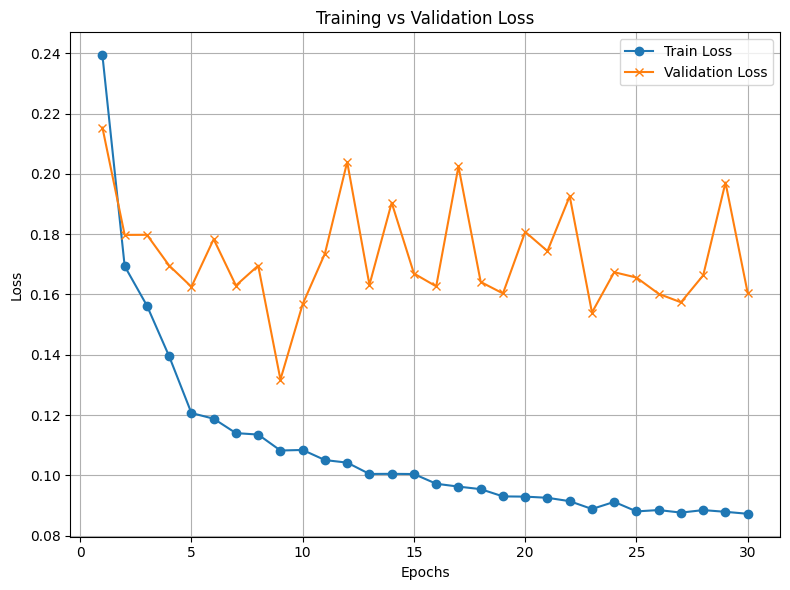

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
torch.save(model, '/mnt/nfs/home/liglesias/repos/nnUNet/nnunetv2/training/nnUNetTrainer/autoencoder_model_2.pth')

In [48]:
torch.save(model.state_dict(), '/mnt/nfs/home/liglesias/repos/nnUNet/nnunetv2/training/nnUNetTrainer/autoencoder_weights_2.pth')

In [46]:
model_weights = "/mnt/nfs/home/liglesias/cardioTFM/cardioTFM/autoencoder_model_2.pth"

trained_model = torch.load(model_weights)
trained_model.to("cuda")

model = Autoencoder()
model.load_state_dict(trained_model.state_dict())

model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)

In [24]:
model = torch.load('/mnt/nfs/home/liglesias/repos/nnUNet/nnunetv2/training/nnUNetTrainer/autoencoder_model_2.pth')
model.to(device)
model.eval()  # Importante para evitar dropout/batch norm en modo entrenamiento
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [69]:
from monai.data import decollate_batch

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_training(sample)
            print(f"Train - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_testing(sample)
            print(f"Validation - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

2025-01-29 23:13:59,109 INFO image_writer.py:197 - writing: reconstructed_masks_testing_all/masks_training/437patient_11_reconstructed.nii.gz
Train - Batch 0 - Shape: torch.Size([1, 196, 240, 13])
2025-01-29 23:13:59,854 INFO image_writer.py:197 - writing: reconstructed_masks_testing_all/masks_training/400patient_01_reconstructed.nii.gz
Train - Batch 1 - Shape: torch.Size([1, 232, 256, 14])
2025-01-29 23:14:00,408 INFO image_writer.py:197 - writing: reconstructed_masks_testing_all/masks_training/356patient_12_reconstructed.nii.gz
Train - Batch 2 - Shape: torch.Size([1, 320, 320, 10])
2025-01-29 23:14:00,850 INFO image_writer.py:197 - writing: reconstructed_masks_testing_all/masks_training/412patient_11_reconstructed.nii.gz
Train - Batch 3 - Shape: torch.Size([1, 320, 320, 10])
2025-01-29 23:14:01,279 INFO image_writer.py:197 - writing: reconstructed_masks_testing_all/masks_training/022patient_01_reconstructed.nii.gz
Train - Batch 4 - Shape: torch.Size([1, 200, 256, 7])
2025-01-29 23:14

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.43301284313201904
Input shape: torch.Size([1, 4, 24, 128, 128])
Output shape: torch.Size([1, 4, 24, 128, 128])
Postprocess output shape: torch.Size([1, 1, 24, 128, 128])


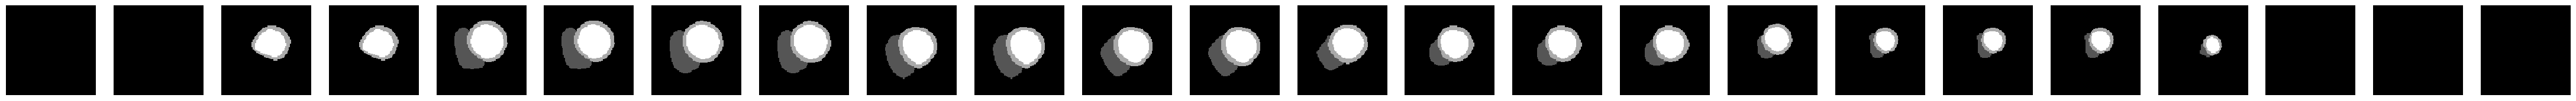

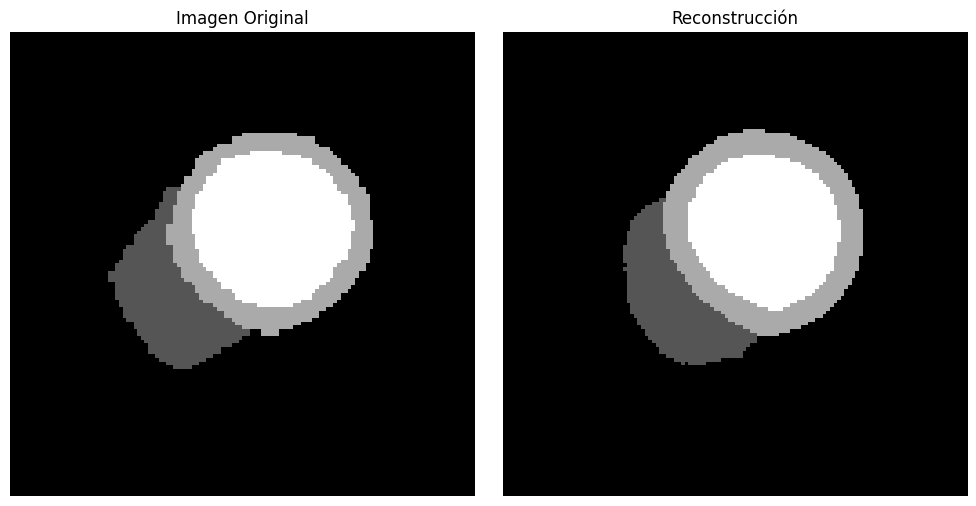

In [70]:
def visualize_axial_reconstruction(model, data_loader, device):
    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.to(device)  # Mover el modelo al dispositivo
    model.eval()
    with torch.no_grad():
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        outputs, _ = model(inputs)

        postprocess_input = postprocess_transform({"image": inputs})["image"]
        postprocess_output = postprocess_transform({"image": outputs})["image"]

        print(f"Input shape: {inputs.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Postprocess output shape: {postprocess_output.shape}")

        slice_idx = postprocess_output.shape[2] // 2  # Índice de la rebanada central
        
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Reconstrucción")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    
visualize_axial_reconstruction(model, val_loader, device)

In [71]:
training_files = list_nifti_files(training_dir)
training_image =  nib.load(training_files[0]) 
header = training_image.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 232 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.         1.3671875  1.3671875 10.         1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
